# 3D patch-based segmentation with U-Net

Code started from [Francesco's tutorials](https://github.com/FrancescoLR/tutorials)



## Imports

In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile
import matplotlib.pyplot as plt


import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, decollate_batch, DataLoader, CacheDataset, Dataset
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ResizeWithPadOrCropd,
    RandCropByPosNegLabeld,
    Lambdad,
    ScaleIntensityd,
)
from monai.utils import first

import ignite
import torch, torchvision

print_config()

/home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1rc3
Numpy version: 1.22.4
Pytorch version: 1.12.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7a5de8b7b9db101a431e70ae2aa8ea7ebb8dfffe
MONAI __file__: /home/jaimebarranco/miniconda3/envs/3dmultilabel/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.1+cu116
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup 


### Paths and cuda check

In [2]:
main_dir = '/mnt/sda1/Repos/a-eye/a-eye_segmentation/3D_multilabel/'
data_dir = '/mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/' # train and validation
test_data_dir = '/mnt/sda1/Repos/a-eye/Data'

[print(f"Data directory is: {data_dir}") if os.path.isdir(data_dir) else print("Check your data directory")]
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(torch.cuda.is_available())

Data directory is: /mnt/sda1/Repos/a-eye/a-eye_preprocessing/ANTs/
True


### Set images and segmentation paths

In [3]:
train_images_1 = []
train_labels_1 = []
validation_images = []
validation_labels = []

# List of subjects taken for the template construction
best_subjects_cc = ['sub-02','sub-03','sub-08','sub-09','sub-20','sub-29','sub-30','sub-33','sub-34'] # 9

# List of remaining subjects
all_subjects = list()
for i in range(35):
    all_subjects.append('sub-'+str(i+1).zfill(2))
rest_subjects = [elem for elem in all_subjects if elem not in best_subjects_cc]

# Train (rest subjects)
for i in range(len(rest_subjects)):
    input_t1 = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + rest_subjects[i] + '/input/' + rest_subjects[i] + '_labels.nii.gz'
    train_images_1.append(input_t1)
    train_labels_1.append(input_labels)
# Train dictionary
data_train_dicts_1 = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images_1, train_labels_1)
]   

# Validation (best subjects)
for i in range(len(best_subjects_cc)):
    input_t1 = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_T1.nii.gz'
    input_labels = data_dir + 'a123/' + best_subjects_cc[i] + '/input/' + best_subjects_cc[i] + '_labels.nii.gz'
    validation_images.append(input_t1)
    validation_labels.append(input_labels)
# Validation dictionary
data_validation_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(validation_images, validation_labels)
]

num_train_samples = len(data_train_dicts_1)
num_validation_samples = len(data_validation_dicts)
num_total_samples = num_train_samples + num_validation_samples
print(f"Train dataset is composed by {len(data_train_dicts_1)} ({num_train_samples/num_total_samples*100:.2f}%) subjects and validation by {len(data_validation_dicts)} ({num_validation_samples/num_total_samples*100:.2f}%).")

Train dataset is composed by 26 (74.29%) subjects and validation by 9 (25.71%).


### Set transforms and dataset

In [4]:
# Function to crop the eye from the medical image
def masked(data_dict):
    eye_mask = (data_dict["label"] != 0)
    eye_mask[eye_mask == True] = 1
    eye_mask[eye_mask == False] = 0
    data_dict["image"] = data_dict["image"] * eye_mask

    return data_dict
    
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]), #Load image file or files from provided path based on reader.
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"]), #Scale the intensity of input image to the given value range (minv, maxv). If minv and maxv and factor not provided, Normalize the data
        EnsureChannelFirstd(keys=["image", "label"]), #Automatically adjust or add the channel dimension of input data to ensure channel_first shape.
        Orientationd(keys=["image", "label"], axcodes="RAS"), #Change the input image’s orientation into the specified based on axcodes.
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160, 160, 160)),
        masked,
        RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. I recommend to use it since improves dice and IoU score
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
    ]    
)

validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        Lambdad(keys=["image"], func=lambda image: torch.nan_to_num(image, nan=0)),
        ScaleIntensityd(keys=["image"],),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1, 1, 1), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(160, 160, 160)),
        masked,
        RandCropByPosNegLabeld( #Crop random fixed sized regions with the center being a foreground or background voxel based on the Pos Neg Ratio. 
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [5]:
train_ds = CacheDataset(
    data=data_train_dicts_1, transform=train_transforms,
    cache_rate=1.0, num_workers=8)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8)

validation_ds = CacheDataset(
    data=data_validation_dicts, transform=validation_transforms, cache_rate=1.0, num_workers=8)
# val_ds = Dataset(data=val_files, transform=val_transforms)
validation_loader = DataLoader(validation_ds, batch_size=1, shuffle=False, num_workers=8)

Loading dataset: 100%|██████████| 9/9 [00:00<00:00, 11.09it/s]


#### Check transforms in DataLoader

N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


image shape: (96, 96, 96), label shape: (96, 96, 96)


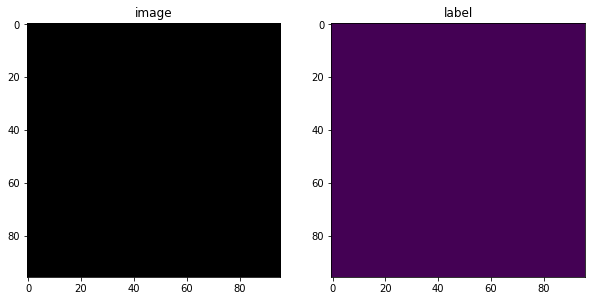

In [6]:
data_iter = iter(validation_loader)
random_data = data_iter.next()
image, label = (random_data["image"][0][0], random_data["label"][0][0]) # [0][0] is to show only the image shape
print(f"image shape: {image.shape}, label shape: {label.shape}")

# plot the slice [:, :, 80]
plt.figure("check", (10,5))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()
#print(len(torch.unique(label)))

#### Save transformed images from validation_loader

In [7]:
# '''
import SimpleITK as sitk

# Saving validation_loader images
i = 0
for _, dict in enumerate(validation_loader):
    print(f"dict: {dict['image'].shape}")
    im_tensors = dict['image']
    print(im_tensors[0].detach().cpu().numpy().shape)
    im_trans = sitk.GetImageFromArray(np.transpose(im_tensors[0].detach().cpu().numpy(), (3,2,1,0)))
    sitk.WriteImage(im_trans, main_dir+'im_trans_masked'+str(i)+'.nii.gz')
    i += 1
    if i == 1:
        break
# '''

N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


dict: (1, 1, 96, 96, 96)
(1, 96, 96, 96)


## Training

### Create Model, Loss, Optimizer

In [8]:
# Create UNet, DiceLoss and Adam optimizer
import gc 
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0")
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 10,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
    dropout = 0.5
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean")

### Train 

In [9]:
FILE = "3dmultilabel_v2.pth"

max_epochs = 150
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_train_loss_values = []
epoch_validation_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=10)])
post_label = Compose([AsDiscrete(to_onehot=10)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_train_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            step_validation = 0
            epoch_validation_loss = 0
            for validation_data in validation_loader:
                step_validation += 1
                validation_inputs, validation_labels = (
                    validation_data["image"].to(device),
                    validation_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4

                # Forward pass
                validation_predictions = model(validation_inputs)
                validation_loss = loss_function(validation_predictions, validation_labels)
                epoch_validation_loss += validation_loss.item()

                # Inference
                validation_outputs = sliding_window_inference(
                    validation_inputs, roi_size, sw_batch_size, model)
                validation_outputs = [post_pred(i) for i in decollate_batch(validation_outputs)]
                validation_labels = [post_label(i) for i in decollate_batch(validation_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=validation_outputs, y=validation_labels)

            epoch_validation_loss /= step_validation
            epoch_validation_loss_values.append(epoch_validation_loss)
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    main_dir, FILE))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.9796
2/13, train_loss: 0.9766
3/13, train_loss: 0.9735
4/13, train_loss: 0.9721
5/13, train_loss: 0.9686
6/13, train_loss: 0.9658
7/13, train_loss: 0.9636
8/13, train_loss: 0.9602
9/13, train_loss: 0.9551
10/13, train_loss: 0.9501
11/13, train_loss: 0.9466
12/13, train_loss: 0.9424
13/13, train_loss: 0.9397
epoch 1 average loss: 0.9611


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 1 current mean dice: 0.0349
best mean dice: 0.0349at epoch: 1
----------
epoch 2/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.9325
2/13, train_loss: 0.9284
3/13, train_loss: 0.9258
4/13, train_loss: 0.9204
5/13, train_loss: 0.9189
6/13, train_loss: 0.9122
7/13, train_loss: 0.9147
8/13, train_loss: 0.9058
9/13, train_loss: 0.9036
10/13, train_loss: 0.8976
11/13, train_loss: 0.8928
12/13, train_loss: 0.8853
13/13, train_loss: 0.8867
epoch 2 average loss: 0.9096


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 2 current mean dice: 0.1147
best mean dice: 0.1147at epoch: 2
----------
epoch 3/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generat

1/13, train_loss: 0.8773
2/13, train_loss: 0.8724
3/13, train_loss: 0.8712
4/13, train_loss: 0.8619
5/13, train_loss: 0.8530
6/13, train_loss: 0.8570
7/13, train_loss: 0.8391
8/13, train_loss: 0.8488
9/13, train_loss: 0.8191
10/13, train_loss: 0.8348
11/13, train_loss: 0.8208
12/13, train_loss: 0.8065
13/13, train_loss: 0.8082
epoch 3 average loss: 0.8439


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 3 current mean dice: 0.1636
best mean dice: 0.1636at epoch: 3
----------
epoch 4/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generat

1/13, train_loss: 0.8087
2/13, train_loss: 0.7988
3/13, train_loss: 0.7971
4/13, train_loss: 0.7832
5/13, train_loss: 0.7894
6/13, train_loss: 0.7982
7/13, train_loss: 0.7778
8/13, train_loss: 0.7978
9/13, train_loss: 0.7588
10/13, train_loss: 0.7647
11/13, train_loss: 0.7506
12/13, train_loss: 0.7698
13/13, train_loss: 0.7459
epoch 4 average loss: 0.7801


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 4 current mean dice: 0.1812
best mean dice: 0.1812at epoch: 4
----------
epoch 5/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.7541
2/13, train_loss: 0.7493
3/13, train_loss: 0.7405
4/13, train_loss: 0.7409
5/13, train_loss: 0.7268
6/13, train_loss: 0.7147
7/13, train_loss: 0.7245
8/13, train_loss: 0.7171
9/13, train_loss: 0.7515
10/13, train_loss: 0.7259
11/13, train_loss: 0.7310
12/13, train_loss: 0.7348
13/13, train_loss: 0.7300
epoch 5 average loss: 0.7339


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 5 current mean dice: 0.2531
best mean dice: 0.2531at epoch: 5
----------
epoch 6/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.7354
2/13, train_loss: 0.7109
3/13, train_loss: 0.7210
4/13, train_loss: 0.6952
5/13, train_loss: 0.7047
6/13, train_loss: 0.6964
7/13, train_loss: 0.7125
8/13, train_loss: 0.6948
9/13, train_loss: 0.7101
10/13, train_loss: 0.6821
11/13, train_loss: 0.6868
12/13, train_loss: 0.6716
13/13, train_loss: 0.6964
epoch 6 average loss: 0.7014


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 6 current mean dice: 0.2807
best mean dice: 0.2807at epoch: 6
----------
epoch 7/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.6824
2/13, train_loss: 0.6691
3/13, train_loss: 0.6928
4/13, train_loss: 0.6712
5/13, train_loss: 0.6799
6/13, train_loss: 0.6787
7/13, train_loss: 0.6574
8/13, train_loss: 0.6760
9/13, train_loss: 0.6599
10/13, train_loss: 0.6520
11/13, train_loss: 0.6625
12/13, train_loss: 0.6567
13/13, train_loss: 0.6439
epoch 7 average loss: 0.6679


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 7 current mean dice: 0.3083
best mean dice: 0.3083at epoch: 7
----------
epoch 8/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.6471
2/13, train_loss: 0.6395
3/13, train_loss: 0.6436
4/13, train_loss: 0.6356
5/13, train_loss: 0.6390
6/13, train_loss: 0.6228
7/13, train_loss: 0.6380
8/13, train_loss: 0.6491
9/13, train_loss: 0.6228
10/13, train_loss: 0.6200
11/13, train_loss: 0.6187
12/13, train_loss: 0.6036
13/13, train_loss: 0.6060
epoch 8 average loss: 0.6297


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 8 current mean dice: 0.3995
best mean dice: 0.3995at epoch: 8
----------
epoch 9/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.6051
2/13, train_loss: 0.5915
3/13, train_loss: 0.5952
4/13, train_loss: 0.5728
5/13, train_loss: 0.5924
6/13, train_loss: 0.5893
7/13, train_loss: 0.5960
8/13, train_loss: 0.5993
9/13, train_loss: 0.5464
10/13, train_loss: 0.5529
11/13, train_loss: 0.5535
12/13, train_loss: 0.5553
13/13, train_loss: 0.5798
epoch 9 average loss: 0.5792


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 9 current mean dice: 0.4799
best mean dice: 0.4799at epoch: 9
----------
epoch 10/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.5687
2/13, train_loss: 0.5432
3/13, train_loss: 0.5542
4/13, train_loss: 0.5342
5/13, train_loss: 0.5702
6/13, train_loss: 0.5486
7/13, train_loss: 0.4974
8/13, train_loss: 0.5178
9/13, train_loss: 0.4955
10/13, train_loss: 0.5231
11/13, train_loss: 0.4766
12/13, train_loss: 0.4875
13/13, train_loss: 0.4584
epoch 10 average loss: 0.5212


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 10 current mean dice: 0.5389
best mean dice: 0.5389at epoch: 10
----------
epoch 11/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.4697
2/13, train_loss: 0.4282
3/13, train_loss: 0.4477
4/13, train_loss: 0.4908
5/13, train_loss: 0.4319
6/13, train_loss: 0.4840
7/13, train_loss: 0.4530
8/13, train_loss: 0.4437
9/13, train_loss: 0.4196
10/13, train_loss: 0.4291
11/13, train_loss: 0.4647
12/13, train_loss: 0.4247
13/13, train_loss: 0.4513
epoch 11 average loss: 0.4491


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 11 current mean dice: 0.6541
best mean dice: 0.6541at epoch: 11
----------
epoch 12/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.4217
2/13, train_loss: 0.4135
3/13, train_loss: 0.3635
4/13, train_loss: 0.4265
5/13, train_loss: 0.4146
6/13, train_loss: 0.4099
7/13, train_loss: 0.4008
8/13, train_loss: 0.4468
9/13, train_loss: 0.3440
10/13, train_loss: 0.3409
11/13, train_loss: 0.3776
12/13, train_loss: 0.4004
13/13, train_loss: 0.3557
epoch 12 average loss: 0.3935


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 12 current mean dice: 0.6782
best mean dice: 0.6782at epoch: 12
----------
epoch 13/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.3991
2/13, train_loss: 0.3940
3/13, train_loss: 0.3850
4/13, train_loss: 0.3614
5/13, train_loss: 0.3558
6/13, train_loss: 0.3649
7/13, train_loss: 0.3560
8/13, train_loss: 0.3324
9/13, train_loss: 0.3249
10/13, train_loss: 0.3925
11/13, train_loss: 0.3793
12/13, train_loss: 0.3264
13/13, train_loss: 0.3365
epoch 13 average loss: 0.3622


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 13 current mean dice: 0.7146
best mean dice: 0.7146at epoch: 13
----------
epoch 14/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.3327
2/13, train_loss: 0.3310
3/13, train_loss: 0.3432
4/13, train_loss: 0.3335
5/13, train_loss: 0.3368
6/13, train_loss: 0.3523
7/13, train_loss: 0.3161
8/13, train_loss: 0.3467
9/13, train_loss: 0.3635
10/13, train_loss: 0.3247
11/13, train_loss: 0.3210
12/13, train_loss: 0.3292
13/13, train_loss: 0.3351
epoch 14 average loss: 0.3358


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 14 current mean dice: 0.6973
best mean dice: 0.7146at epoch: 13
----------
epoch 15/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.3179
2/13, train_loss: 0.3616
3/13, train_loss: 0.3034
4/13, train_loss: 0.3460
5/13, train_loss: 0.3370
6/13, train_loss: 0.3712
7/13, train_loss: 0.2950
8/13, train_loss: 0.2946
9/13, train_loss: 0.3493
10/13, train_loss: 0.3153
11/13, train_loss: 0.3534
12/13, train_loss: 0.3764
13/13, train_loss: 0.3130
epoch 15 average loss: 0.3334


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 15 current mean dice: 0.6983
best mean dice: 0.7146at epoch: 13
----------
epoch 16/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generat

1/13, train_loss: 0.3278
2/13, train_loss: 0.3268
3/13, train_loss: 0.2909
4/13, train_loss: 0.3162
5/13, train_loss: 0.3074
6/13, train_loss: 0.3329
7/13, train_loss: 0.3322
8/13, train_loss: 0.3384
9/13, train_loss: 0.3166
10/13, train_loss: 0.3104
11/13, train_loss: 0.2728
12/13, train_loss: 0.3263
13/13, train_loss: 0.3452
epoch 16 average loss: 0.3188


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 16 current mean dice: 0.7271
best mean dice: 0.7271at epoch: 16
----------
epoch 17/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.2912
2/13, train_loss: 0.3267
3/13, train_loss: 0.2987
4/13, train_loss: 0.2960
5/13, train_loss: 0.2959
6/13, train_loss: 0.3046
7/13, train_loss: 0.3085
8/13, train_loss: 0.2633
9/13, train_loss: 0.3051
10/13, train_loss: 0.3225
11/13, train_loss: 0.3064
12/13, train_loss: 0.3175
13/13, train_loss: 0.3335
epoch 17 average loss: 0.3054


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 17 current mean dice: 0.7112
best mean dice: 0.7271at epoch: 16
----------
epoch 18/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generat

1/13, train_loss: 0.2809
2/13, train_loss: 0.2892
3/13, train_loss: 0.3022
4/13, train_loss: 0.2805
5/13, train_loss: 0.2897
6/13, train_loss: 0.2751
7/13, train_loss: 0.3166
8/13, train_loss: 0.3099
9/13, train_loss: 0.2901
10/13, train_loss: 0.2751
11/13, train_loss: 0.3253
12/13, train_loss: 0.3064
13/13, train_loss: 0.3263
epoch 18 average loss: 0.2975


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 18 current mean dice: 0.7404
best mean dice: 0.7404at epoch: 18
----------
epoch 19/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.2787
2/13, train_loss: 0.2865
3/13, train_loss: 0.2829
4/13, train_loss: 0.2766
5/13, train_loss: 0.3157
6/13, train_loss: 0.3201
7/13, train_loss: 0.2809
8/13, train_loss: 0.3369
9/13, train_loss: 0.2509
10/13, train_loss: 0.3002
11/13, train_loss: 0.2993
12/13, train_loss: 0.2956
13/13, train_loss: 0.2693
epoch 19 average loss: 0.2918


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 19 current mean dice: 0.7310
best mean dice: 0.7404at epoch: 18
----------
epoch 20/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.3396
2/13, train_loss: 0.2935
3/13, train_loss: 0.2761
4/13, train_loss: 0.2689
5/13, train_loss: 0.2933
6/13, train_loss: 0.2606
7/13, train_loss: 0.2849
8/13, train_loss: 0.2638
9/13, train_loss: 0.2768
10/13, train_loss: 0.2636
11/13, train_loss: 0.2856
12/13, train_loss: 0.2797
13/13, train_loss: 0.3028
epoch 20 average loss: 0.2838


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 20 current mean dice: 0.7528
best mean dice: 0.7528at epoch: 20
----------
epoch 21/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.2566
2/13, train_loss: 0.2986
3/13, train_loss: 0.2390
4/13, train_loss: 0.2926
5/13, train_loss: 0.3032
6/13, train_loss: 0.2815
7/13, train_loss: 0.2605
8/13, train_loss: 0.2644
9/13, train_loss: 0.2774
10/13, train_loss: 0.2664
11/13, train_loss: 0.2469
12/13, train_loss: 0.2752
13/13, train_loss: 0.3026
epoch 21 average loss: 0.2742


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 21 current mean dice: 0.7515
best mean dice: 0.7528at epoch: 20
----------
epoch 22/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generat

1/13, train_loss: 0.2836
2/13, train_loss: 0.2494
3/13, train_loss: 0.2604
4/13, train_loss: 0.2630
5/13, train_loss: 0.2942
6/13, train_loss: 0.2608
7/13, train_loss: 0.2893
8/13, train_loss: 0.2684
9/13, train_loss: 0.2823
10/13, train_loss: 0.2738
11/13, train_loss: 0.2474
12/13, train_loss: 0.2825
13/13, train_loss: 0.2698
epoch 22 average loss: 0.2712


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 22 current mean dice: 0.7519
best mean dice: 0.7528at epoch: 20
----------
epoch 23/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.2199
2/13, train_loss: 0.2614
3/13, train_loss: 0.2703
4/13, train_loss: 0.2630
5/13, train_loss: 0.2857
6/13, train_loss: 0.3027
7/13, train_loss: 0.2799
8/13, train_loss: 0.2865
9/13, train_loss: 0.2698
10/13, train_loss: 0.2743
11/13, train_loss: 0.2477
12/13, train_loss: 0.2677
13/13, train_loss: 0.2697
epoch 23 average loss: 0.2691


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 23 current mean dice: 0.7614
best mean dice: 0.7614at epoch: 23
----------
epoch 24/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.2863
2/13, train_loss: 0.2424
3/13, train_loss: 0.2622
4/13, train_loss: 0.2639
5/13, train_loss: 0.2652
6/13, train_loss: 0.2586
7/13, train_loss: 0.2533
8/13, train_loss: 0.2565
9/13, train_loss: 0.2740
10/13, train_loss: 0.2932
11/13, train_loss: 0.2398
12/13, train_loss: 0.2585
13/13, train_loss: 0.3138
epoch 24 average loss: 0.2668


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 24 current mean dice: 0.7560
best mean dice: 0.7614at epoch: 23
----------
epoch 25/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generat

1/13, train_loss: 0.2734
2/13, train_loss: 0.2520
3/13, train_loss: 0.2590
4/13, train_loss: 0.2587
5/13, train_loss: 0.2934
6/13, train_loss: 0.2719
7/13, train_loss: 0.2611
8/13, train_loss: 0.2694
9/13, train_loss: 0.2738
10/13, train_loss: 0.2427
11/13, train_loss: 0.2584
12/13, train_loss: 0.2584
13/13, train_loss: 0.2477
epoch 25 average loss: 0.2631


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 25 current mean dice: 0.7619
best mean dice: 0.7619at epoch: 25
----------
epoch 26/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.2356
2/13, train_loss: 0.2933
3/13, train_loss: 0.2473
4/13, train_loss: 0.2910
5/13, train_loss: 0.2369
6/13, train_loss: 0.2536
7/13, train_loss: 0.2657
8/13, train_loss: 0.2419
9/13, train_loss: 0.2768
10/13, train_loss: 0.2891
11/13, train_loss: 0.2589
12/13, train_loss: 0.2572
13/13, train_loss: 0.2596
epoch 26 average loss: 0.2621


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 26 current mean dice: 0.7670
best mean dice: 0.7670at epoch: 26
----------
epoch 27/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.2891
2/13, train_loss: 0.2579
3/13, train_loss: 0.2250
4/13, train_loss: 0.2550
5/13, train_loss: 0.2598
6/13, train_loss: 0.2409
7/13, train_loss: 0.2899
8/13, train_loss: 0.2235
9/13, train_loss: 0.2844
10/13, train_loss: 0.2673
11/13, train_loss: 0.2674
12/13, train_loss: 0.2605
13/13, train_loss: 0.2544
epoch 27 average loss: 0.2596


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 27 current mean dice: 0.7719
best mean dice: 0.7719at epoch: 27
----------
epoch 28/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.2497
2/13, train_loss: 0.2527
3/13, train_loss: 0.2516
4/13, train_loss: 0.2533
5/13, train_loss: 0.2559
6/13, train_loss: 0.2923
7/13, train_loss: 0.2593
8/13, train_loss: 0.2535
9/13, train_loss: 0.2407
10/13, train_loss: 0.2466
11/13, train_loss: 0.2346
12/13, train_loss: 0.2420
13/13, train_loss: 0.2627
epoch 28 average loss: 0.2534


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 28 current mean dice: 0.7831
best mean dice: 0.7831at epoch: 28
----------
epoch 29/150


N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.2299
2/13, train_loss: 0.2383
3/13, train_loss: 0.2552
4/13, train_loss: 0.2506
5/13, train_loss: 0.2269
6/13, train_loss: 0.2535
7/13, train_loss: 0.2392
8/13, train_loss: 0.2741
9/13, train_loss: 0.2146
10/13, train_loss: 0.2556
11/13, train_loss: 0.2393
12/13, train_loss: 0.2481
13/13, train_loss: 0.2712
epoch 29 average loss: 0.2459


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 29 current mean dice: 0.7878
best mean dice: 0.7878at epoch: 29
----------
epoch 30/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.2564
2/13, train_loss: 0.2687
3/13, train_loss: 0.2329
4/13, train_loss: 0.2633
5/13, train_loss: 0.2382
6/13, train_loss: 0.2676
7/13, train_loss: 0.2290
8/13, train_loss: 0.2940
9/13, train_loss: 0.2432
10/13, train_loss: 0.2502
11/13, train_loss: 0.2387
12/13, train_loss: 0.2183
13/13, train_loss: 0.2329
epoch 30 average loss: 0.2487


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 30 current mean dice: 0.7886
best mean dice: 0.7886at epoch: 30
----------
epoch 31/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.2463
2/13, train_loss: 0.2044
3/13, train_loss: 0.2377
4/13, train_loss: 0.2416
5/13, train_loss: 0.2590
6/13, train_loss: 0.2499
7/13, train_loss: 0.2807
8/13, train_loss: 0.2443
9/13, train_loss: 0.2241
10/13, train_loss: 0.2411
11/13, train_loss: 0.2209
12/13, train_loss: 0.2713
13/13, train_loss: 0.2455
epoch 31 average loss: 0.2436


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 31 current mean dice: 0.7747
best mean dice: 0.7886at epoch: 30
----------
epoch 32/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.2741
2/13, train_loss: 0.2361
3/13, train_loss: 0.2393
4/13, train_loss: 0.2292
5/13, train_loss: 0.2168
6/13, train_loss: 0.2254
7/13, train_loss: 0.2577
8/13, train_loss: 0.2506
9/13, train_loss: 0.2566
10/13, train_loss: 0.2364
11/13, train_loss: 0.2416
12/13, train_loss: 0.2332
13/13, train_loss: 0.2325
epoch 32 average loss: 0.2407


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 32 current mean dice: 0.7913
best mean dice: 0.7913at epoch: 32
----------
epoch 33/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to genera

1/13, train_loss: 0.2350
2/13, train_loss: 0.2483
3/13, train_loss: 0.2255
4/13, train_loss: 0.2497
5/13, train_loss: 0.2846
6/13, train_loss: 0.2379
7/13, train_loss: 0.2498
8/13, train_loss: 0.2290
9/13, train_loss: 0.2236
10/13, train_loss: 0.2105
11/13, train_loss: 0.2459
12/13, train_loss: 0.2404
13/13, train_loss: 0.2426
epoch 33 average loss: 0.2402


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 33 current mean dice: 0.7855
best mean dice: 0.7913at epoch: 32
----------
epoch 34/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.2437
2/13, train_loss: 0.2458
3/13, train_loss: 0.2281
4/13, train_loss: 0.2446
5/13, train_loss: 0.2443
6/13, train_loss: 0.2358
7/13, train_loss: 0.2091
8/13, train_loss: 0.2596
9/13, train_loss: 0.2031
10/13, train_loss: 0.2361
11/13, train_loss: 0.2172
12/13, train_loss: 0.2280
13/13, train_loss: 0.2401
epoch 34 average loss: 0.2335


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 34 current mean dice: 0.7961
best mean dice: 0.7961at epoch: 34
----------
epoch 35/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.2393
2/13, train_loss: 0.2448
3/13, train_loss: 0.1909
4/13, train_loss: 0.2408
5/13, train_loss: 0.2064
6/13, train_loss: 0.2264
7/13, train_loss: 0.2123
8/13, train_loss: 0.2293
9/13, train_loss: 0.2356
10/13, train_loss: 0.2282
11/13, train_loss: 0.2539
12/13, train_loss: 0.2220
13/13, train_loss: 0.2535
epoch 35 average loss: 0.2295


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 35 current mean dice: 0.7920
best mean dice: 0.7961at epoch: 34
----------
epoch 36/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.2434
2/13, train_loss: 0.2678
3/13, train_loss: 0.2155
4/13, train_loss: 0.2481
5/13, train_loss: 0.2401
6/13, train_loss: 0.2157
7/13, train_loss: 0.2348
8/13, train_loss: 0.2283
9/13, train_loss: 0.2300
10/13, train_loss: 0.2244
11/13, train_loss: 0.2350
12/13, train_loss: 0.2244
13/13, train_loss: 0.2233
epoch 36 average loss: 0.2331


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 36 current mean dice: 0.7987
best mean dice: 0.7987at epoch: 36
----------
epoch 37/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.2117
2/13, train_loss: 0.2432
3/13, train_loss: 0.2264
4/13, train_loss: 0.2226
5/13, train_loss: 0.2333
6/13, train_loss: 0.2359
7/13, train_loss: 0.2279
8/13, train_loss: 0.2420
9/13, train_loss: 0.2402
10/13, train_loss: 0.2206
11/13, train_loss: 0.2383
12/13, train_loss: 0.2286
13/13, train_loss: 0.2189
epoch 37 average loss: 0.2300


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 37 current mean dice: 0.8020
best mean dice: 0.8020at epoch: 37
----------
epoch 38/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to genera

1/13, train_loss: 0.2302
2/13, train_loss: 0.2225
3/13, train_loss: 0.2426
4/13, train_loss: 0.2394
5/13, train_loss: 0.2442
6/13, train_loss: 0.2022
7/13, train_loss: 0.2238
8/13, train_loss: 0.2347
9/13, train_loss: 0.2249
10/13, train_loss: 0.2225
11/13, train_loss: 0.2318
12/13, train_loss: 0.2206
13/13, train_loss: 0.2051
epoch 38 average loss: 0.2265


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 38 current mean dice: 0.8077
best mean dice: 0.8077at epoch: 38
----------
epoch 39/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to genera

1/13, train_loss: 0.2300
2/13, train_loss: 0.2133
3/13, train_loss: 0.2167
4/13, train_loss: 0.2271
5/13, train_loss: 0.2213
6/13, train_loss: 0.2172
7/13, train_loss: 0.2308
8/13, train_loss: 0.2283
9/13, train_loss: 0.2323
10/13, train_loss: 0.1991
11/13, train_loss: 0.2280
12/13, train_loss: 0.2645
13/13, train_loss: 0.2531
epoch 39 average loss: 0.2278


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 39 current mean dice: 0.7948
best mean dice: 0.8077at epoch: 38
----------
epoch 40/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.2237
2/13, train_loss: 0.2221
3/13, train_loss: 0.2134
4/13, train_loss: 0.2280
5/13, train_loss: 0.2278
6/13, train_loss: 0.2215
7/13, train_loss: 0.2107
8/13, train_loss: 0.2299
9/13, train_loss: 0.2198
10/13, train_loss: 0.2163
11/13, train_loss: 0.1772
12/13, train_loss: 0.2163
13/13, train_loss: 0.2425
epoch 40 average loss: 0.2192


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 40 current mean dice: 0.8016
best mean dice: 0.8077at epoch: 38
----------
epoch 41/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.2141
2/13, train_loss: 0.2206
3/13, train_loss: 0.2420
4/13, train_loss: 0.2029
5/13, train_loss: 0.2503
6/13, train_loss: 0.2138
7/13, train_loss: 0.2239
8/13, train_loss: 0.2222
9/13, train_loss: 0.2245
10/13, train_loss: 0.1977
11/13, train_loss: 0.2098
12/13, train_loss: 0.2103
13/13, train_loss: 0.2290
epoch 41 average loss: 0.2201


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 41 current mean dice: 0.8041
best mean dice: 0.8077at epoch: 38
----------
epoch 42/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to genera

1/13, train_loss: 0.2057
2/13, train_loss: 0.2148
3/13, train_loss: 0.2046
4/13, train_loss: 0.2477
5/13, train_loss: 0.2007
6/13, train_loss: 0.2070
7/13, train_loss: 0.2163
8/13, train_loss: 0.2298
9/13, train_loss: 0.2265
10/13, train_loss: 0.2246
11/13, train_loss: 0.2244
12/13, train_loss: 0.2404
13/13, train_loss: 0.2368
epoch 42 average loss: 0.2215


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 42 current mean dice: 0.7891
best mean dice: 0.8077at epoch: 38
----------
epoch 43/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generat

1/13, train_loss: 0.2239
2/13, train_loss: 0.2164
3/13, train_loss: 0.2204
4/13, train_loss: 0.1978
5/13, train_loss: 0.2102
6/13, train_loss: 0.2374
7/13, train_loss: 0.2091
8/13, train_loss: 0.2308
9/13, train_loss: 0.2247
10/13, train_loss: 0.2272
11/13, train_loss: 0.2210
12/13, train_loss: 0.2170
13/13, train_loss: 0.2319
epoch 43 average loss: 0.2206


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 43 current mean dice: 0.8122
best mean dice: 0.8122at epoch: 43
----------
epoch 44/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.2288
2/13, train_loss: 0.2389
3/13, train_loss: 0.2306
4/13, train_loss: 0.2145
5/13, train_loss: 0.1963
6/13, train_loss: 0.2313
7/13, train_loss: 0.2180
8/13, train_loss: 0.2142
9/13, train_loss: 0.2043
10/13, train_loss: 0.2156
11/13, train_loss: 0.2318
12/13, train_loss: 0.2085
13/13, train_loss: 0.1873
epoch 44 average loss: 0.2169


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 44 current mean dice: 0.8098
best mean dice: 0.8122at epoch: 43
----------
epoch 45/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.2078
2/13, train_loss: 0.2313
3/13, train_loss: 0.2084
4/13, train_loss: 0.2163
5/13, train_loss: 0.2100
6/13, train_loss: 0.2439
7/13, train_loss: 0.2276
8/13, train_loss: 0.1945
9/13, train_loss: 0.2372
10/13, train_loss: 0.2364
11/13, train_loss: 0.2165
12/13, train_loss: 0.1937
13/13, train_loss: 0.2082
epoch 45 average loss: 0.2178


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 45 current mean dice: 0.8036
best mean dice: 0.8122at epoch: 43
----------
epoch 46/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to genera

1/13, train_loss: 0.2074
2/13, train_loss: 0.2001
3/13, train_loss: 0.2388
4/13, train_loss: 0.2112
5/13, train_loss: 0.1992
6/13, train_loss: 0.2097
7/13, train_loss: 0.2174
8/13, train_loss: 0.2039
9/13, train_loss: 0.2157
10/13, train_loss: 0.2260
11/13, train_loss: 0.2047
12/13, train_loss: 0.2027
13/13, train_loss: 0.2264
epoch 46 average loss: 0.2126


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 46 current mean dice: 0.8039
best mean dice: 0.8122at epoch: 43
----------
epoch 47/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.2237
2/13, train_loss: 0.2131
3/13, train_loss: 0.2174
4/13, train_loss: 0.1950
5/13, train_loss: 0.2166
6/13, train_loss: 0.2050
7/13, train_loss: 0.2111
8/13, train_loss: 0.2118
9/13, train_loss: 0.2152
10/13, train_loss: 0.2193
11/13, train_loss: 0.2153
12/13, train_loss: 0.2194
13/13, train_loss: 0.2151
epoch 47 average loss: 0.2137


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 47 current mean dice: 0.8108
best mean dice: 0.8122at epoch: 43
----------
epoch 48/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generat

1/13, train_loss: 0.2278
2/13, train_loss: 0.1901
3/13, train_loss: 0.2141
4/13, train_loss: 0.2072
5/13, train_loss: 0.2311
6/13, train_loss: 0.2223
7/13, train_loss: 0.1871
8/13, train_loss: 0.2042
9/13, train_loss: 0.1935
10/13, train_loss: 0.2107
11/13, train_loss: 0.2242
12/13, train_loss: 0.2117
13/13, train_loss: 0.2081
epoch 48 average loss: 0.2102


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 48 current mean dice: 0.8087
best mean dice: 0.8122at epoch: 43
----------
epoch 49/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.2138
2/13, train_loss: 0.1998
3/13, train_loss: 0.1761
4/13, train_loss: 0.2115
5/13, train_loss: 0.1992
6/13, train_loss: 0.2107
7/13, train_loss: 0.1984
8/13, train_loss: 0.2266
9/13, train_loss: 0.2093
10/13, train_loss: 0.2249
11/13, train_loss: 0.2301
12/13, train_loss: 0.2018
13/13, train_loss: 0.1994
epoch 49 average loss: 0.2078


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 49 current mean dice: 0.8226
best mean dice: 0.8226at epoch: 49
----------
epoch 50/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.1966
2/13, train_loss: 0.2101
3/13, train_loss: 0.2048
4/13, train_loss: 0.2027
5/13, train_loss: 0.2069
6/13, train_loss: 0.2086
7/13, train_loss: 0.2326
8/13, train_loss: 0.2277
9/13, train_loss: 0.1893
10/13, train_loss: 0.1847
11/13, train_loss: 0.1955
12/13, train_loss: 0.2255
13/13, train_loss: 0.2202
epoch 50 average loss: 0.2081


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 50 current mean dice: 0.8042
best mean dice: 0.8226at epoch: 49
----------
epoch 51/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.2143
2/13, train_loss: 0.2107
3/13, train_loss: 0.2244
4/13, train_loss: 0.1860
5/13, train_loss: 0.1990
6/13, train_loss: 0.2140
7/13, train_loss: 0.2073
8/13, train_loss: 0.1837
9/13, train_loss: 0.2233
10/13, train_loss: 0.2023
11/13, train_loss: 0.2157
12/13, train_loss: 0.2241
13/13, train_loss: 0.2192
epoch 51 average loss: 0.2095


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 51 current mean dice: 0.8095
best mean dice: 0.8226at epoch: 49
----------
epoch 52/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to genera

1/13, train_loss: 0.2134
2/13, train_loss: 0.2056
3/13, train_loss: 0.2153
4/13, train_loss: 0.1891
5/13, train_loss: 0.2197
6/13, train_loss: 0.2145
7/13, train_loss: 0.1977
8/13, train_loss: 0.2010
9/13, train_loss: 0.1973
10/13, train_loss: 0.1916
11/13, train_loss: 0.1984
12/13, train_loss: 0.2028
13/13, train_loss: 0.2407
epoch 52 average loss: 0.2067


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 52 current mean dice: 0.8139
best mean dice: 0.8226at epoch: 49
----------
epoch 53/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.2182
2/13, train_loss: 0.1999
3/13, train_loss: 0.1978
4/13, train_loss: 0.2131
5/13, train_loss: 0.1991
6/13, train_loss: 0.2060
7/13, train_loss: 0.2045
8/13, train_loss: 0.1943
9/13, train_loss: 0.2133
10/13, train_loss: 0.2280
11/13, train_loss: 0.2073
12/13, train_loss: 0.2209
13/13, train_loss: 0.2251
epoch 53 average loss: 0.2098


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 53 current mean dice: 0.8112
best mean dice: 0.8226at epoch: 49
----------
epoch 54/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to genera

1/13, train_loss: 0.1853
2/13, train_loss: 0.1718
3/13, train_loss: 0.2100
4/13, train_loss: 0.1860
5/13, train_loss: 0.1942
6/13, train_loss: 0.2021
7/13, train_loss: 0.2474
8/13, train_loss: 0.2306
9/13, train_loss: 0.2078
10/13, train_loss: 0.1973
11/13, train_loss: 0.2142
12/13, train_loss: 0.2136
13/13, train_loss: 0.2097
epoch 54 average loss: 0.2054


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 54 current mean dice: 0.8121
best mean dice: 0.8226at epoch: 49
----------
epoch 55/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.2004
2/13, train_loss: 0.2098
3/13, train_loss: 0.2177
4/13, train_loss: 0.2040
5/13, train_loss: 0.2012
6/13, train_loss: 0.2322
7/13, train_loss: 0.2085
8/13, train_loss: 0.2214
9/13, train_loss: 0.2094
10/13, train_loss: 0.1961
11/13, train_loss: 0.2052
12/13, train_loss: 0.1925
13/13, train_loss: 0.1790
epoch 55 average loss: 0.2059


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 55 current mean dice: 0.8149
best mean dice: 0.8226at epoch: 49
----------
epoch 56/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.2028
2/13, train_loss: 0.2081
3/13, train_loss: 0.2061
4/13, train_loss: 0.1755
5/13, train_loss: 0.2046
6/13, train_loss: 0.1996
7/13, train_loss: 0.1897
8/13, train_loss: 0.2055
9/13, train_loss: 0.1973
10/13, train_loss: 0.1994
11/13, train_loss: 0.2280
12/13, train_loss: 0.2040
13/13, train_loss: 0.1898
epoch 56 average loss: 0.2008


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 56 current mean dice: 0.8183
best mean dice: 0.8226at epoch: 49
----------
epoch 57/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1901
2/13, train_loss: 0.2057
3/13, train_loss: 0.2057
4/13, train_loss: 0.2217
5/13, train_loss: 0.1859
6/13, train_loss: 0.2121
7/13, train_loss: 0.1858
8/13, train_loss: 0.2078
9/13, train_loss: 0.1941
10/13, train_loss: 0.1880
11/13, train_loss: 0.2131
12/13, train_loss: 0.1954
13/13, train_loss: 0.2033
epoch 57 average loss: 0.2007


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 57 current mean dice: 0.8186
best mean dice: 0.8226at epoch: 49
----------
epoch 58/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to genera

1/13, train_loss: 0.1982
2/13, train_loss: 0.1998
3/13, train_loss: 0.1861
4/13, train_loss: 0.2125
5/13, train_loss: 0.1899
6/13, train_loss: 0.2059
7/13, train_loss: 0.2034
8/13, train_loss: 0.1919
9/13, train_loss: 0.1900
10/13, train_loss: 0.2076
11/13, train_loss: 0.2086
12/13, train_loss: 0.1892
13/13, train_loss: 0.1839
epoch 58 average loss: 0.1975


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 58 current mean dice: 0.8188
best mean dice: 0.8226at epoch: 49
----------
epoch 59/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generat

1/13, train_loss: 0.1998
2/13, train_loss: 0.1913
3/13, train_loss: 0.1848
4/13, train_loss: 0.2023
5/13, train_loss: 0.2024
6/13, train_loss: 0.2099
7/13, train_loss: 0.1856
8/13, train_loss: 0.2101
9/13, train_loss: 0.2106
10/13, train_loss: 0.1900
11/13, train_loss: 0.1943
12/13, train_loss: 0.1957
13/13, train_loss: 0.1992
epoch 59 average loss: 0.1982


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 59 current mean dice: 0.8211
best mean dice: 0.8226at epoch: 49
----------
epoch 60/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.2078
2/13, train_loss: 0.1934
3/13, train_loss: 0.1992
4/13, train_loss: 0.1990
5/13, train_loss: 0.1913
6/13, train_loss: 0.2039
7/13, train_loss: 0.2026
8/13, train_loss: 0.1993
9/13, train_loss: 0.2019
10/13, train_loss: 0.2163
11/13, train_loss: 0.1899
12/13, train_loss: 0.1817
13/13, train_loss: 0.2014
epoch 60 average loss: 0.1991


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 60 current mean dice: 0.8181
best mean dice: 0.8226at epoch: 49
----------
epoch 61/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to genera

1/13, train_loss: 0.1860
2/13, train_loss: 0.2061
3/13, train_loss: 0.2084
4/13, train_loss: 0.1980
5/13, train_loss: 0.1775
6/13, train_loss: 0.2038
7/13, train_loss: 0.1921
8/13, train_loss: 0.2071
9/13, train_loss: 0.2034
10/13, train_loss: 0.1851
11/13, train_loss: 0.1972
12/13, train_loss: 0.2387
13/13, train_loss: 0.1792
epoch 61 average loss: 0.1987


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 61 current mean dice: 0.8148
best mean dice: 0.8226at epoch: 49
----------
epoch 62/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generat

1/13, train_loss: 0.1764
2/13, train_loss: 0.2042
3/13, train_loss: 0.2122
4/13, train_loss: 0.2005
5/13, train_loss: 0.2179
6/13, train_loss: 0.1806
7/13, train_loss: 0.2025
8/13, train_loss: 0.2047
9/13, train_loss: 0.2090
10/13, train_loss: 0.1912
11/13, train_loss: 0.2008
12/13, train_loss: 0.1956
13/13, train_loss: 0.2102
epoch 62 average loss: 0.2005


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 62 current mean dice: 0.8244
best mean dice: 0.8244at epoch: 62
----------
epoch 63/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.2184
2/13, train_loss: 0.1950
3/13, train_loss: 0.1904
4/13, train_loss: 0.2046
5/13, train_loss: 0.1972
6/13, train_loss: 0.2116
7/13, train_loss: 0.1878
8/13, train_loss: 0.2091
9/13, train_loss: 0.1869
10/13, train_loss: 0.2127
11/13, train_loss: 0.1777
12/13, train_loss: 0.1911
13/13, train_loss: 0.1923
epoch 63 average loss: 0.1980


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 63 current mean dice: 0.8248
best mean dice: 0.8248at epoch: 63
----------
epoch 64/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generat

1/13, train_loss: 0.1855
2/13, train_loss: 0.1805
3/13, train_loss: 0.1872
4/13, train_loss: 0.1974
5/13, train_loss: 0.1936
6/13, train_loss: 0.2038
7/13, train_loss: 0.2151
8/13, train_loss: 0.1891
9/13, train_loss: 0.2161
10/13, train_loss: 0.1976
11/13, train_loss: 0.2101
12/13, train_loss: 0.2031
13/13, train_loss: 0.1898
epoch 64 average loss: 0.1976


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 64 current mean dice: 0.8183
best mean dice: 0.8248at epoch: 63
----------
epoch 65/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generat

1/13, train_loss: 0.1675
2/13, train_loss: 0.2125
3/13, train_loss: 0.1962
4/13, train_loss: 0.1907
5/13, train_loss: 0.2054
6/13, train_loss: 0.1938
7/13, train_loss: 0.1993
8/13, train_loss: 0.2095
9/13, train_loss: 0.1940
10/13, train_loss: 0.1942
11/13, train_loss: 0.1874
12/13, train_loss: 0.1944
13/13, train_loss: 0.1820
epoch 65 average loss: 0.1944


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 65 current mean dice: 0.8277
best mean dice: 0.8277at epoch: 65
----------
epoch 66/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.2077
2/13, train_loss: 0.1746
3/13, train_loss: 0.1897
4/13, train_loss: 0.2089
5/13, train_loss: 0.1837
6/13, train_loss: 0.2028
7/13, train_loss: 0.1812
8/13, train_loss: 0.2018
9/13, train_loss: 0.1729
10/13, train_loss: 0.1788
11/13, train_loss: 0.2128
12/13, train_loss: 0.2060
13/13, train_loss: 0.1917
epoch 66 average loss: 0.1933


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 66 current mean dice: 0.8268
best mean dice: 0.8277at epoch: 65
----------
epoch 67/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.1901
2/13, train_loss: 0.1784
3/13, train_loss: 0.2067
4/13, train_loss: 0.1890
5/13, train_loss: 0.1955
6/13, train_loss: 0.1893
7/13, train_loss: 0.2084
8/13, train_loss: 0.2020
9/13, train_loss: 0.1936
10/13, train_loss: 0.1740
11/13, train_loss: 0.1839
12/13, train_loss: 0.1743
13/13, train_loss: 0.2309
epoch 67 average loss: 0.1935


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 67 current mean dice: 0.8140
best mean dice: 0.8277at epoch: 65
----------
epoch 68/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1783
2/13, train_loss: 0.1960
3/13, train_loss: 0.2106
4/13, train_loss: 0.1909
5/13, train_loss: 0.2044
6/13, train_loss: 0.2151
7/13, train_loss: 0.2094
8/13, train_loss: 0.1869
9/13, train_loss: 0.2011
10/13, train_loss: 0.1949
11/13, train_loss: 0.1954
12/13, train_loss: 0.1762
13/13, train_loss: 0.1887
epoch 68 average loss: 0.1960


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 68 current mean dice: 0.8273
best mean dice: 0.8277at epoch: 65
----------
epoch 69/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generat

1/13, train_loss: 0.2145
2/13, train_loss: 0.1948
3/13, train_loss: 0.1832
4/13, train_loss: 0.1965
5/13, train_loss: 0.1795
6/13, train_loss: 0.2065
7/13, train_loss: 0.2144
8/13, train_loss: 0.1756
9/13, train_loss: 0.1853
10/13, train_loss: 0.1713
11/13, train_loss: 0.1896
12/13, train_loss: 0.1885
13/13, train_loss: 0.1923
epoch 69 average loss: 0.1917


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 69 current mean dice: 0.8325
best mean dice: 0.8325at epoch: 69
----------
epoch 70/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.1939
2/13, train_loss: 0.1902
3/13, train_loss: 0.1852
4/13, train_loss: 0.1810
5/13, train_loss: 0.2446
6/13, train_loss: 0.1887
7/13, train_loss: 0.2006
8/13, train_loss: 0.2007
9/13, train_loss: 0.1997
10/13, train_loss: 0.1798
11/13, train_loss: 0.1820
12/13, train_loss: 0.1936
13/13, train_loss: 0.1766
epoch 70 average loss: 0.1936


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 70 current mean dice: 0.8250
best mean dice: 0.8325at epoch: 69
----------
epoch 71/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1939
2/13, train_loss: 0.1833
3/13, train_loss: 0.1933
4/13, train_loss: 0.1948
5/13, train_loss: 0.1957
6/13, train_loss: 0.1947
7/13, train_loss: 0.1771
8/13, train_loss: 0.1955
9/13, train_loss: 0.1904
10/13, train_loss: 0.1959
11/13, train_loss: 0.1904
12/13, train_loss: 0.1662
13/13, train_loss: 0.1855
epoch 71 average loss: 0.1890


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 71 current mean dice: 0.8296
best mean dice: 0.8325at epoch: 69
----------
epoch 72/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generat

1/13, train_loss: 0.1831
2/13, train_loss: 0.1949
3/13, train_loss: 0.1951
4/13, train_loss: 0.2033
5/13, train_loss: 0.2029
6/13, train_loss: 0.1717
7/13, train_loss: 0.1881
8/13, train_loss: 0.2042
9/13, train_loss: 0.1687
10/13, train_loss: 0.1957
11/13, train_loss: 0.1939
12/13, train_loss: 0.1960
13/13, train_loss: 0.1820
epoch 72 average loss: 0.1907


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 72 current mean dice: 0.8283
best mean dice: 0.8325at epoch: 69
----------
epoch 73/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1818
2/13, train_loss: 0.1937
3/13, train_loss: 0.1956
4/13, train_loss: 0.1915
5/13, train_loss: 0.1762
6/13, train_loss: 0.1947
7/13, train_loss: 0.2015
8/13, train_loss: 0.1744
9/13, train_loss: 0.1921
10/13, train_loss: 0.1752
11/13, train_loss: 0.1961
12/13, train_loss: 0.1852
13/13, train_loss: 0.1950
epoch 73 average loss: 0.1887


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 73 current mean dice: 0.8253
best mean dice: 0.8325at epoch: 69
----------
epoch 74/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generat

1/13, train_loss: 0.2104
2/13, train_loss: 0.1862
3/13, train_loss: 0.1971
4/13, train_loss: 0.2098
5/13, train_loss: 0.1770
6/13, train_loss: 0.1810
7/13, train_loss: 0.1780
8/13, train_loss: 0.1906
9/13, train_loss: 0.1717
10/13, train_loss: 0.1814
11/13, train_loss: 0.1942
12/13, train_loss: 0.1836
13/13, train_loss: 0.1927
epoch 74 average loss: 0.1887


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 74 current mean dice: 0.8217
best mean dice: 0.8325at epoch: 69
----------
epoch 75/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.1759
2/13, train_loss: 0.1855
3/13, train_loss: 0.1947
4/13, train_loss: 0.2072
5/13, train_loss: 0.1934
6/13, train_loss: 0.2001
7/13, train_loss: 0.1628
8/13, train_loss: 0.1930
9/13, train_loss: 0.1938
10/13, train_loss: 0.1777
11/13, train_loss: 0.1926
12/13, train_loss: 0.1766
13/13, train_loss: 0.1828
epoch 75 average loss: 0.1874


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 75 current mean dice: 0.8317
best mean dice: 0.8325at epoch: 69
----------
epoch 76/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generat

1/13, train_loss: 0.1808
2/13, train_loss: 0.1749
3/13, train_loss: 0.1780
4/13, train_loss: 0.1853
5/13, train_loss: 0.2020
6/13, train_loss: 0.2121
7/13, train_loss: 0.1880
8/13, train_loss: 0.1684
9/13, train_loss: 0.1780
10/13, train_loss: 0.2045
11/13, train_loss: 0.1702
12/13, train_loss: 0.1812
13/13, train_loss: 0.1929
epoch 76 average loss: 0.1859


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 76 current mean dice: 0.8334
best mean dice: 0.8334at epoch: 76
----------
epoch 77/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1662
2/13, train_loss: 0.1815
3/13, train_loss: 0.1553
4/13, train_loss: 0.1782
5/13, train_loss: 0.1786
6/13, train_loss: 0.1844
7/13, train_loss: 0.1872
8/13, train_loss: 0.2042
9/13, train_loss: 0.1945
10/13, train_loss: 0.1915
11/13, train_loss: 0.1959
12/13, train_loss: 0.2117
13/13, train_loss: 0.1904
epoch 77 average loss: 0.1861


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 77 current mean dice: 0.8154
best mean dice: 0.8334at epoch: 76
----------
epoch 78/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.2006
2/13, train_loss: 0.1835
3/13, train_loss: 0.1897
4/13, train_loss: 0.2045
5/13, train_loss: 0.1979
6/13, train_loss: 0.1760
7/13, train_loss: 0.1710
8/13, train_loss: 0.1912
9/13, train_loss: 0.1933
10/13, train_loss: 0.1678
11/13, train_loss: 0.2177
12/13, train_loss: 0.1757
13/13, train_loss: 0.1893
epoch 78 average loss: 0.1891


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 78 current mean dice: 0.8282
best mean dice: 0.8334at epoch: 76
----------
epoch 79/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1944
2/13, train_loss: 0.1897
3/13, train_loss: 0.1787
4/13, train_loss: 0.1725
5/13, train_loss: 0.1842
6/13, train_loss: 0.1814
7/13, train_loss: 0.1811
8/13, train_loss: 0.1751
9/13, train_loss: 0.1689
10/13, train_loss: 0.1943
11/13, train_loss: 0.1756
12/13, train_loss: 0.2128
13/13, train_loss: 0.1906
epoch 79 average loss: 0.1846


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 79 current mean dice: 0.8312
best mean dice: 0.8334at epoch: 76
----------
epoch 80/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1913
2/13, train_loss: 0.1891
3/13, train_loss: 0.1768
4/13, train_loss: 0.1673
5/13, train_loss: 0.2086
6/13, train_loss: 0.1914
7/13, train_loss: 0.1821
8/13, train_loss: 0.1870
9/13, train_loss: 0.1843
10/13, train_loss: 0.1855
11/13, train_loss: 0.1962
12/13, train_loss: 0.1469
13/13, train_loss: 0.1792
epoch 80 average loss: 0.1835


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 80 current mean dice: 0.8328
best mean dice: 0.8334at epoch: 76
----------
epoch 81/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1679
2/13, train_loss: 0.1721
3/13, train_loss: 0.1683
4/13, train_loss: 0.1815
5/13, train_loss: 0.1806
6/13, train_loss: 0.1913
7/13, train_loss: 0.2041
8/13, train_loss: 0.1600
9/13, train_loss: 0.1817
10/13, train_loss: 0.1945
11/13, train_loss: 0.1784
12/13, train_loss: 0.1862
13/13, train_loss: 0.1854
epoch 81 average loss: 0.1809


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 81 current mean dice: 0.8377
best mean dice: 0.8377at epoch: 81
----------
epoch 82/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.1879
2/13, train_loss: 0.1829
3/13, train_loss: 0.1752
4/13, train_loss: 0.1817
5/13, train_loss: 0.1614
6/13, train_loss: 0.1765
7/13, train_loss: 0.1843
8/13, train_loss: 0.1797
9/13, train_loss: 0.1882
10/13, train_loss: 0.1937
11/13, train_loss: 0.1999
12/13, train_loss: 0.1825
13/13, train_loss: 0.1712
epoch 82 average loss: 0.1819


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 82 current mean dice: 0.8288
best mean dice: 0.8377at epoch: 81
----------
epoch 83/150


N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to genera

1/13, train_loss: 0.1658
2/13, train_loss: 0.1852
3/13, train_loss: 0.1910
4/13, train_loss: 0.1847
5/13, train_loss: 0.1798
6/13, train_loss: 0.1719
7/13, train_loss: 0.1851
8/13, train_loss: 0.1846
9/13, train_loss: 0.2057
10/13, train_loss: 0.1751
11/13, train_loss: 0.1776
12/13, train_loss: 0.1801
13/13, train_loss: 0.1887
epoch 83 average loss: 0.1827


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 83 current mean dice: 0.8358
best mean dice: 0.8377at epoch: 81
----------
epoch 84/150


N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1891
2/13, train_loss: 0.1822
3/13, train_loss: 0.1594
4/13, train_loss: 0.1900
5/13, train_loss: 0.1891
6/13, train_loss: 0.1782
7/13, train_loss: 0.1793
8/13, train_loss: 0.1797
9/13, train_loss: 0.1797
10/13, train_loss: 0.1688
11/13, train_loss: 0.1944
12/13, train_loss: 0.1921
13/13, train_loss: 0.1793
epoch 84 average loss: 0.1816


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 84 current mean dice: 0.8341
best mean dice: 0.8377at epoch: 81
----------
epoch 85/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1748
2/13, train_loss: 0.1766
3/13, train_loss: 0.1620
4/13, train_loss: 0.1690
5/13, train_loss: 0.1834
6/13, train_loss: 0.1552
7/13, train_loss: 0.1966
8/13, train_loss: 0.1669
9/13, train_loss: 0.1844
10/13, train_loss: 0.1987
11/13, train_loss: 0.1908
12/13, train_loss: 0.1801
13/13, train_loss: 0.1900
epoch 85 average loss: 0.1791


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 85 current mean dice: 0.8321
best mean dice: 0.8377at epoch: 81
----------
epoch 86/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1670
2/13, train_loss: 0.1858
3/13, train_loss: 0.1728
4/13, train_loss: 0.1826
5/13, train_loss: 0.1764
6/13, train_loss: 0.1825
7/13, train_loss: 0.1903
8/13, train_loss: 0.1766
9/13, train_loss: 0.1763
10/13, train_loss: 0.1766
11/13, train_loss: 0.1978
12/13, train_loss: 0.1750
13/13, train_loss: 0.1731
epoch 86 average loss: 0.1794


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 86 current mean dice: 0.8414
best mean dice: 0.8414at epoch: 86
----------
epoch 87/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generat

1/13, train_loss: 0.2011
2/13, train_loss: 0.1703
3/13, train_loss: 0.1720
4/13, train_loss: 0.1665
5/13, train_loss: 0.1771
6/13, train_loss: 0.1796
7/13, train_loss: 0.1772
8/13, train_loss: 0.2087
9/13, train_loss: 0.1753
10/13, train_loss: 0.1731
11/13, train_loss: 0.1776
12/13, train_loss: 0.1810
13/13, train_loss: 0.1821
epoch 87 average loss: 0.1801


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 87 current mean dice: 0.8369
best mean dice: 0.8414at epoch: 86
----------
epoch 88/150


N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generat

1/13, train_loss: 0.1680
2/13, train_loss: 0.1885
3/13, train_loss: 0.1812
4/13, train_loss: 0.1618
5/13, train_loss: 0.1813
6/13, train_loss: 0.1797
7/13, train_loss: 0.1940
8/13, train_loss: 0.1781
9/13, train_loss: 0.1735
10/13, train_loss: 0.1642
11/13, train_loss: 0.1975
12/13, train_loss: 0.1905
13/13, train_loss: 0.1847
epoch 88 average loss: 0.1802


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 88 current mean dice: 0.8143
best mean dice: 0.8414at epoch: 86
----------
epoch 89/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.1689
2/13, train_loss: 0.1673
3/13, train_loss: 0.1824
4/13, train_loss: 0.1721
5/13, train_loss: 0.1936
6/13, train_loss: 0.1690
7/13, train_loss: 0.1791
8/13, train_loss: 0.1768
9/13, train_loss: 0.1569
10/13, train_loss: 0.2065
11/13, train_loss: 0.1844
12/13, train_loss: 0.1970
13/13, train_loss: 0.2023
epoch 89 average loss: 0.1812


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 89 current mean dice: 0.8330
best mean dice: 0.8414at epoch: 86
----------
epoch 90/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1856
2/13, train_loss: 0.1697
3/13, train_loss: 0.1652
4/13, train_loss: 0.2002
5/13, train_loss: 0.1916
6/13, train_loss: 0.1707
7/13, train_loss: 0.1695
8/13, train_loss: 0.1760
9/13, train_loss: 0.1818
10/13, train_loss: 0.1795
11/13, train_loss: 0.1722
12/13, train_loss: 0.1765
13/13, train_loss: 0.1865
epoch 90 average loss: 0.1788


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 90 current mean dice: 0.8337
best mean dice: 0.8414at epoch: 86
----------
epoch 91/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1928
2/13, train_loss: 0.1926
3/13, train_loss: 0.1755
4/13, train_loss: 0.1901
5/13, train_loss: 0.1910
6/13, train_loss: 0.1659
7/13, train_loss: 0.1803
8/13, train_loss: 0.1663
9/13, train_loss: 0.1737
10/13, train_loss: 0.1634
11/13, train_loss: 0.1931
12/13, train_loss: 0.1743
13/13, train_loss: 0.1858
epoch 91 average loss: 0.1804


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 91 current mean dice: 0.8399
best mean dice: 0.8414at epoch: 86
----------
epoch 92/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generat

1/13, train_loss: 0.1624
2/13, train_loss: 0.1951
3/13, train_loss: 0.1637
4/13, train_loss: 0.1733
5/13, train_loss: 0.1961
6/13, train_loss: 0.1795
7/13, train_loss: 0.1760
8/13, train_loss: 0.1679
9/13, train_loss: 0.1859
10/13, train_loss: 0.1602
11/13, train_loss: 0.1759
12/13, train_loss: 0.1762
13/13, train_loss: 0.1830
epoch 92 average loss: 0.1766


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 92 current mean dice: 0.8362
best mean dice: 0.8414at epoch: 86
----------
epoch 93/150


N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generat

1/13, train_loss: 0.1792
2/13, train_loss: 0.1913
3/13, train_loss: 0.1737
4/13, train_loss: 0.1904
5/13, train_loss: 0.1804
6/13, train_loss: 0.1632
7/13, train_loss: 0.1782
8/13, train_loss: 0.1779
9/13, train_loss: 0.1877
10/13, train_loss: 0.1711
11/13, train_loss: 0.1776
12/13, train_loss: 0.1725
13/13, train_loss: 0.1750
epoch 93 average loss: 0.1783


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 93 current mean dice: 0.8417
best mean dice: 0.8417at epoch: 93
----------
epoch 94/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generat

1/13, train_loss: 0.1776
2/13, train_loss: 0.1728
3/13, train_loss: 0.1725
4/13, train_loss: 0.1964
5/13, train_loss: 0.1786
6/13, train_loss: 0.1687
7/13, train_loss: 0.1801
8/13, train_loss: 0.1699
9/13, train_loss: 0.1730
10/13, train_loss: 0.1727
11/13, train_loss: 0.1914
12/13, train_loss: 0.1894
13/13, train_loss: 0.1762
epoch 94 average loss: 0.1784


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 94 current mean dice: 0.8404
best mean dice: 0.8417at epoch: 93
----------
epoch 95/150


N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to genera

1/13, train_loss: 0.1882
2/13, train_loss: 0.1813
3/13, train_loss: 0.1645
4/13, train_loss: 0.1762
5/13, train_loss: 0.1790
6/13, train_loss: 0.1556
7/13, train_loss: 0.1669
8/13, train_loss: 0.1735
9/13, train_loss: 0.1772
10/13, train_loss: 0.1854
11/13, train_loss: 0.1917
12/13, train_loss: 0.1651
13/13, train_loss: 0.1638
epoch 95 average loss: 0.1745


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 95 current mean dice: 0.8372
best mean dice: 0.8417at epoch: 93
----------
epoch 96/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to genera

1/13, train_loss: 0.1794
2/13, train_loss: 0.1582
3/13, train_loss: 0.1906
4/13, train_loss: 0.1812
5/13, train_loss: 0.1712
6/13, train_loss: 0.1694
7/13, train_loss: 0.1885
8/13, train_loss: 0.1805
9/13, train_loss: 0.1835
10/13, train_loss: 0.1651
11/13, train_loss: 0.1843
12/13, train_loss: 0.1732
13/13, train_loss: 0.1694
epoch 96 average loss: 0.1765


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 96 current mean dice: 0.8422
best mean dice: 0.8422at epoch: 96
----------
epoch 97/150


N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.1531
2/13, train_loss: 0.1886
3/13, train_loss: 0.1782
4/13, train_loss: 0.1735
5/13, train_loss: 0.1613
6/13, train_loss: 0.1777
7/13, train_loss: 0.1836
8/13, train_loss: 0.1663
9/13, train_loss: 0.1553
10/13, train_loss: 0.1702
11/13, train_loss: 0.1820
12/13, train_loss: 0.1677
13/13, train_loss: 0.1843
epoch 97 average loss: 0.1724


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 97 current mean dice: 0.8407
best mean dice: 0.8422at epoch: 96
----------
epoch 98/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to genera

1/13, train_loss: 0.1771
2/13, train_loss: 0.1751
3/13, train_loss: 0.1817
4/13, train_loss: 0.1618
5/13, train_loss: 0.1700
6/13, train_loss: 0.1796
7/13, train_loss: 0.1631
8/13, train_loss: 0.1776
9/13, train_loss: 0.1852
10/13, train_loss: 0.1551
11/13, train_loss: 0.1821
12/13, train_loss: 0.1802
13/13, train_loss: 0.1728
epoch 98 average loss: 0.1740


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 98 current mean dice: 0.8465
best mean dice: 0.8465at epoch: 98
----------
epoch 99/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1728
2/13, train_loss: 0.1634
3/13, train_loss: 0.1893
4/13, train_loss: 0.1851
5/13, train_loss: 0.1877
6/13, train_loss: 0.1695
7/13, train_loss: 0.1741
8/13, train_loss: 0.1729
9/13, train_loss: 0.1866
10/13, train_loss: 0.1748
11/13, train_loss: 0.1662
12/13, train_loss: 0.1746
13/13, train_loss: 0.1616
epoch 99 average loss: 0.1753


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 99 current mean dice: 0.8437
best mean dice: 0.8465at epoch: 98
----------
epoch 100/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1814
2/13, train_loss: 0.1848
3/13, train_loss: 0.1625
4/13, train_loss: 0.1759
5/13, train_loss: 0.1663
6/13, train_loss: 0.1705
7/13, train_loss: 0.1805
8/13, train_loss: 0.1925
9/13, train_loss: 0.1737
10/13, train_loss: 0.1608
11/13, train_loss: 0.1740
12/13, train_loss: 0.1855
13/13, train_loss: 0.1780
epoch 100 average loss: 0.1759


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 100 current mean dice: 0.8379
best mean dice: 0.8465at epoch: 98
----------
epoch 101/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generat

1/13, train_loss: 0.1821
2/13, train_loss: 0.1732
3/13, train_loss: 0.1690
4/13, train_loss: 0.1720
5/13, train_loss: 0.1858
6/13, train_loss: 0.1700
7/13, train_loss: 0.1796
8/13, train_loss: 0.1604
9/13, train_loss: 0.1836
10/13, train_loss: 0.1547
11/13, train_loss: 0.1686
12/13, train_loss: 0.1605
13/13, train_loss: 0.1807
epoch 101 average loss: 0.1723


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 101 current mean dice: 0.8388
best mean dice: 0.8465at epoch: 98
----------
epoch 102/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.1496
2/13, train_loss: 0.1796
3/13, train_loss: 0.1750
4/13, train_loss: 0.1701
5/13, train_loss: 0.1872
6/13, train_loss: 0.1600
7/13, train_loss: 0.1552
8/13, train_loss: 0.1546
9/13, train_loss: 0.1720
10/13, train_loss: 0.1570
11/13, train_loss: 0.1745
12/13, train_loss: 0.1701
13/13, train_loss: 0.1743
epoch 102 average loss: 0.1676


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 102 current mean dice: 0.8392
best mean dice: 0.8465at epoch: 98
----------
epoch 103/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generat

1/13, train_loss: 0.1694
2/13, train_loss: 0.1611
3/13, train_loss: 0.1860
4/13, train_loss: 0.1848
5/13, train_loss: 0.1543
6/13, train_loss: 0.1545
7/13, train_loss: 0.1727
8/13, train_loss: 0.1697
9/13, train_loss: 0.1797
10/13, train_loss: 0.1817
11/13, train_loss: 0.1793
12/13, train_loss: 0.1638
13/13, train_loss: 0.1740
epoch 103 average loss: 0.1716


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 103 current mean dice: 0.8460
best mean dice: 0.8465at epoch: 98
----------
epoch 104/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1615
2/13, train_loss: 0.1663
3/13, train_loss: 0.1595
4/13, train_loss: 0.1772
5/13, train_loss: 0.1807
6/13, train_loss: 0.1583
7/13, train_loss: 0.1614
8/13, train_loss: 0.1692
9/13, train_loss: 0.1633
10/13, train_loss: 0.1650
11/13, train_loss: 0.1804
12/13, train_loss: 0.1761
13/13, train_loss: 0.1849
epoch 104 average loss: 0.1695


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 104 current mean dice: 0.8462
best mean dice: 0.8465at epoch: 98
----------
epoch 105/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to genera

1/13, train_loss: 0.1656
2/13, train_loss: 0.1512
3/13, train_loss: 0.1491
4/13, train_loss: 0.1590
5/13, train_loss: 0.1794
6/13, train_loss: 0.1657
7/13, train_loss: 0.1798
8/13, train_loss: 0.1758
9/13, train_loss: 0.1679
10/13, train_loss: 0.1461
11/13, train_loss: 0.1915
12/13, train_loss: 0.1711
13/13, train_loss: 0.1812
epoch 105 average loss: 0.1679


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 105 current mean dice: 0.8446
best mean dice: 0.8465at epoch: 98
----------
epoch 106/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generat

1/13, train_loss: 0.1514
2/13, train_loss: 0.1615
3/13, train_loss: 0.1731
4/13, train_loss: 0.1704
5/13, train_loss: 0.1660
6/13, train_loss: 0.1608
7/13, train_loss: 0.1615
8/13, train_loss: 0.1686
9/13, train_loss: 0.1760
10/13, train_loss: 0.1736
11/13, train_loss: 0.1678
12/13, train_loss: 0.1713
13/13, train_loss: 0.1668
epoch 106 average loss: 0.1668


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 106 current mean dice: 0.8453
best mean dice: 0.8465at epoch: 98
----------
epoch 107/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1502
2/13, train_loss: 0.1744
3/13, train_loss: 0.1794
4/13, train_loss: 0.1605
5/13, train_loss: 0.1852
6/13, train_loss: 0.1764
7/13, train_loss: 0.1752
8/13, train_loss: 0.1799
9/13, train_loss: 0.1671
10/13, train_loss: 0.1532
11/13, train_loss: 0.1638
12/13, train_loss: 0.1665
13/13, train_loss: 0.1669
epoch 107 average loss: 0.1691


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 107 current mean dice: 0.8453
best mean dice: 0.8465at epoch: 98
----------
epoch 108/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to genera

1/13, train_loss: 0.1620
2/13, train_loss: 0.1758
3/13, train_loss: 0.1782
4/13, train_loss: 0.1655
5/13, train_loss: 0.1624
6/13, train_loss: 0.1690
7/13, train_loss: 0.1735
8/13, train_loss: 0.1671
9/13, train_loss: 0.1655
10/13, train_loss: 0.1712
11/13, train_loss: 0.1654
12/13, train_loss: 0.1736
13/13, train_loss: 0.1429
epoch 108 average loss: 0.1671


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 108 current mean dice: 0.8441
best mean dice: 0.8465at epoch: 98
----------
epoch 109/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generat

1/13, train_loss: 0.1686
2/13, train_loss: 0.1617
3/13, train_loss: 0.1559
4/13, train_loss: 0.1719
5/13, train_loss: 0.1681
6/13, train_loss: 0.1580
7/13, train_loss: 0.1794
8/13, train_loss: 0.1704
9/13, train_loss: 0.1697
10/13, train_loss: 0.1676
11/13, train_loss: 0.1573
12/13, train_loss: 0.1532
13/13, train_loss: 0.1575
epoch 109 average loss: 0.1646


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 109 current mean dice: 0.8429
best mean dice: 0.8465at epoch: 98
----------
epoch 110/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.1509
2/13, train_loss: 0.1715
3/13, train_loss: 0.1781
4/13, train_loss: 0.1566
5/13, train_loss: 0.1713
6/13, train_loss: 0.1624
7/13, train_loss: 0.1746
8/13, train_loss: 0.1819
9/13, train_loss: 0.1681
10/13, train_loss: 0.1697
11/13, train_loss: 0.1783
12/13, train_loss: 0.1516
13/13, train_loss: 0.1706
epoch 110 average loss: 0.1681


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 110 current mean dice: 0.8465
best mean dice: 0.8465at epoch: 110
----------
epoch 111/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to genera

1/13, train_loss: 0.1680
2/13, train_loss: 0.1700
3/13, train_loss: 0.1830
4/13, train_loss: 0.1826
5/13, train_loss: 0.1485
6/13, train_loss: 0.1716
7/13, train_loss: 0.1646
8/13, train_loss: 0.1564
9/13, train_loss: 0.1745
10/13, train_loss: 0.1770
11/13, train_loss: 0.1476
12/13, train_loss: 0.1893
13/13, train_loss: 0.1549
epoch 111 average loss: 0.1683


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 111 current mean dice: 0.8479
best mean dice: 0.8479at epoch: 111
----------
epoch 112/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generat

1/13, train_loss: 0.1510
2/13, train_loss: 0.1667
3/13, train_loss: 0.1763
4/13, train_loss: 0.1738
5/13, train_loss: 0.1555
6/13, train_loss: 0.1695
7/13, train_loss: 0.1818
8/13, train_loss: 0.1587
9/13, train_loss: 0.1691
10/13, train_loss: 0.1807
11/13, train_loss: 0.1597
12/13, train_loss: 0.1630
13/13, train_loss: 0.1599
epoch 112 average loss: 0.1666


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 112 current mean dice: 0.8475
best mean dice: 0.8479at epoch: 111
----------
epoch 113/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to genera

1/13, train_loss: 0.1655
2/13, train_loss: 0.1626
3/13, train_loss: 0.1617
4/13, train_loss: 0.1535
5/13, train_loss: 0.1753
6/13, train_loss: 0.1682
7/13, train_loss: 0.1562
8/13, train_loss: 0.1660
9/13, train_loss: 0.1570
10/13, train_loss: 0.1718
11/13, train_loss: 0.1681
12/13, train_loss: 0.1564
13/13, train_loss: 0.1881
epoch 113 average loss: 0.1654


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 113 current mean dice: 0.8477
best mean dice: 0.8479at epoch: 111
----------
epoch 114/150


N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.1682
2/13, train_loss: 0.1544
3/13, train_loss: 0.1548
4/13, train_loss: 0.1592
5/13, train_loss: 0.1755
6/13, train_loss: 0.1674
7/13, train_loss: 0.1653
8/13, train_loss: 0.1576
9/13, train_loss: 0.1653
10/13, train_loss: 0.1730
11/13, train_loss: 0.1632
12/13, train_loss: 0.1682
13/13, train_loss: 0.1665
epoch 114 average loss: 0.1645


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 114 current mean dice: 0.8526
best mean dice: 0.8526at epoch: 114
----------
epoch 115/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to genera

1/13, train_loss: 0.1518
2/13, train_loss: 0.1699
3/13, train_loss: 0.1746
4/13, train_loss: 0.1642
5/13, train_loss: 0.1672
6/13, train_loss: 0.1837
7/13, train_loss: 0.1504
8/13, train_loss: 0.1581
9/13, train_loss: 0.1627
10/13, train_loss: 0.1782
11/13, train_loss: 0.1777
12/13, train_loss: 0.1495
13/13, train_loss: 0.1666
epoch 115 average loss: 0.1657


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 115 current mean dice: 0.8449
best mean dice: 0.8526at epoch: 114
----------
epoch 116/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to genera

1/13, train_loss: 0.1550
2/13, train_loss: 0.1714
3/13, train_loss: 0.1519
4/13, train_loss: 0.1502
5/13, train_loss: 0.1661
6/13, train_loss: 0.1666
7/13, train_loss: 0.1751
8/13, train_loss: 0.1739
9/13, train_loss: 0.1578
10/13, train_loss: 0.1695
11/13, train_loss: 0.1644
12/13, train_loss: 0.1798
13/13, train_loss: 0.1528
epoch 116 average loss: 0.1642


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 116 current mean dice: 0.8504
best mean dice: 0.8526at epoch: 114
----------
epoch 117/150


N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.1746
2/13, train_loss: 0.1612
3/13, train_loss: 0.1503
4/13, train_loss: 0.1671
5/13, train_loss: 0.1757
6/13, train_loss: 0.1575
7/13, train_loss: 0.1744
8/13, train_loss: 0.1492
9/13, train_loss: 0.1309
10/13, train_loss: 0.1623
11/13, train_loss: 0.1787
12/13, train_loss: 0.1622
13/13, train_loss: 0.1601
epoch 117 average loss: 0.1619


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 117 current mean dice: 0.8524
best mean dice: 0.8526at epoch: 114
----------
epoch 118/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to genera

1/13, train_loss: 0.1684
2/13, train_loss: 0.1731
3/13, train_loss: 0.1504
4/13, train_loss: 0.1628
5/13, train_loss: 0.1714
6/13, train_loss: 0.1619
7/13, train_loss: 0.1631
8/13, train_loss: 0.1540
9/13, train_loss: 0.1621
10/13, train_loss: 0.1639
11/13, train_loss: 0.1578
12/13, train_loss: 0.1775
13/13, train_loss: 0.1604
epoch 118 average loss: 0.1636


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 118 current mean dice: 0.8508
best mean dice: 0.8526at epoch: 114
----------
epoch 119/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1742
2/13, train_loss: 0.1754
3/13, train_loss: 0.1633
4/13, train_loss: 0.1720
5/13, train_loss: 0.1619
6/13, train_loss: 0.1761
7/13, train_loss: 0.1629
8/13, train_loss: 0.1516
9/13, train_loss: 0.1594
10/13, train_loss: 0.1597
11/13, train_loss: 0.1584
12/13, train_loss: 0.1550
13/13, train_loss: 0.1569
epoch 119 average loss: 0.1636


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 119 current mean dice: 0.8503
best mean dice: 0.8526at epoch: 114
----------
epoch 120/150


N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generat

1/13, train_loss: 0.1672
2/13, train_loss: 0.1584
3/13, train_loss: 0.1558
4/13, train_loss: 0.1634
5/13, train_loss: 0.1493
6/13, train_loss: 0.1480
7/13, train_loss: 0.1535
8/13, train_loss: 0.1764
9/13, train_loss: 0.1625
10/13, train_loss: 0.1595
11/13, train_loss: 0.1543
12/13, train_loss: 0.1757
13/13, train_loss: 0.1616
epoch 120 average loss: 0.1604


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 120 current mean dice: 0.8460
best mean dice: 0.8526at epoch: 114
----------
epoch 121/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1768
2/13, train_loss: 0.1653
3/13, train_loss: 0.1571
4/13, train_loss: 0.1641
5/13, train_loss: 0.1532
6/13, train_loss: 0.1750
7/13, train_loss: 0.1625
8/13, train_loss: 0.1683
9/13, train_loss: 0.1546
10/13, train_loss: 0.1623
11/13, train_loss: 0.1574
12/13, train_loss: 0.1711
13/13, train_loss: 0.1593
epoch 121 average loss: 0.1636


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 121 current mean dice: 0.8544
best mean dice: 0.8544at epoch: 121
----------
epoch 122/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to genera

1/13, train_loss: 0.1631
2/13, train_loss: 0.1572
3/13, train_loss: 0.1668
4/13, train_loss: 0.1637
5/13, train_loss: 0.1485
6/13, train_loss: 0.1604
7/13, train_loss: 0.1678
8/13, train_loss: 0.1697
9/13, train_loss: 0.1629
10/13, train_loss: 0.1562
11/13, train_loss: 0.1629
12/13, train_loss: 0.1556
13/13, train_loss: 0.1744
epoch 122 average loss: 0.1623


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 122 current mean dice: 0.8521
best mean dice: 0.8544at epoch: 121
----------
epoch 123/150


N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1614
2/13, train_loss: 0.1619
3/13, train_loss: 0.1611
4/13, train_loss: 0.1594
5/13, train_loss: 0.1426
6/13, train_loss: 0.1555
7/13, train_loss: 0.1477
8/13, train_loss: 0.1692
9/13, train_loss: 0.1603
10/13, train_loss: 0.1728
11/13, train_loss: 0.1552
12/13, train_loss: 0.1569
13/13, train_loss: 0.1668
epoch 123 average loss: 0.1593


N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 123 current mean dice: 0.8462
best mean dice: 0.8544at epoch: 121
----------
epoch 124/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to genera

1/13, train_loss: 0.1625
2/13, train_loss: 0.1570
3/13, train_loss: 0.1593
4/13, train_loss: 0.1530
5/13, train_loss: 0.1727
6/13, train_loss: 0.1548
7/13, train_loss: 0.1550
8/13, train_loss: 0.1628
9/13, train_loss: 0.1598
10/13, train_loss: 0.1677
11/13, train_loss: 0.1624
12/13, train_loss: 0.1632
13/13, train_loss: 0.1648
epoch 124 average loss: 0.1612


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 124 current mean dice: 0.8496
best mean dice: 0.8544at epoch: 121
----------
epoch 125/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generat

1/13, train_loss: 0.1557
2/13, train_loss: 0.1580
3/13, train_loss: 0.1607
4/13, train_loss: 0.1622
5/13, train_loss: 0.1651
6/13, train_loss: 0.1734
7/13, train_loss: 0.1640
8/13, train_loss: 0.1624
9/13, train_loss: 0.1474
10/13, train_loss: 0.1514
11/13, train_loss: 0.1551
12/13, train_loss: 0.1606
13/13, train_loss: 0.1582
epoch 125 average loss: 0.1595


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 125 current mean dice: 0.8563
best mean dice: 0.8563at epoch: 125
----------
epoch 126/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to genera

1/13, train_loss: 0.1387
2/13, train_loss: 0.1712
3/13, train_loss: 0.1570
4/13, train_loss: 0.1621
5/13, train_loss: 0.1519
6/13, train_loss: 0.1686
7/13, train_loss: 0.1599
8/13, train_loss: 0.1707
9/13, train_loss: 0.1580
10/13, train_loss: 0.1657
11/13, train_loss: 0.1565
12/13, train_loss: 0.1522
13/13, train_loss: 0.1737
epoch 126 average loss: 0.1605


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 126 current mean dice: 0.8526
best mean dice: 0.8563at epoch: 125
----------
epoch 127/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to genera

1/13, train_loss: 0.1671
2/13, train_loss: 0.1626
3/13, train_loss: 0.1617
4/13, train_loss: 0.1491
5/13, train_loss: 0.1688
6/13, train_loss: 0.1702
7/13, train_loss: 0.1529
8/13, train_loss: 0.1590
9/13, train_loss: 0.1711
10/13, train_loss: 0.1570
11/13, train_loss: 0.1546
12/13, train_loss: 0.1473
13/13, train_loss: 0.1705
epoch 127 average loss: 0.1609


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 127 current mean dice: 0.8533
best mean dice: 0.8563at epoch: 125
----------
epoch 128/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.1620
2/13, train_loss: 0.1593
3/13, train_loss: 0.1496
4/13, train_loss: 0.1746
5/13, train_loss: 0.1638
6/13, train_loss: 0.1583
7/13, train_loss: 0.1599
8/13, train_loss: 0.1822
9/13, train_loss: 0.1465
10/13, train_loss: 0.1579
11/13, train_loss: 0.1440
12/13, train_loss: 0.1605
13/13, train_loss: 0.1667
epoch 128 average loss: 0.1604


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 128 current mean dice: 0.8571
best mean dice: 0.8571at epoch: 128
----------
epoch 129/150


N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to genera

1/13, train_loss: 0.1592
2/13, train_loss: 0.1698
3/13, train_loss: 0.1472
4/13, train_loss: 0.1478
5/13, train_loss: 0.1667
6/13, train_loss: 0.1589
7/13, train_loss: 0.1465
8/13, train_loss: 0.1633
9/13, train_loss: 0.1721
10/13, train_loss: 0.1418
11/13, train_loss: 0.1668
12/13, train_loss: 0.1460
13/13, train_loss: 0.1560
epoch 129 average loss: 0.1571


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 129 current mean dice: 0.8556
best mean dice: 0.8571at epoch: 128
----------
epoch 130/150


N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.1407
2/13, train_loss: 0.1566
3/13, train_loss: 0.1583
4/13, train_loss: 0.1457
5/13, train_loss: 0.1509
6/13, train_loss: 0.1610
7/13, train_loss: 0.1477
8/13, train_loss: 0.1710
9/13, train_loss: 0.1629
10/13, train_loss: 0.1628
11/13, train_loss: 0.1662
12/13, train_loss: 0.1481
13/13, train_loss: 0.1677
epoch 130 average loss: 0.1569


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 130 current mean dice: 0.8567
best mean dice: 0.8571at epoch: 128
----------
epoch 131/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1575
2/13, train_loss: 0.1560
3/13, train_loss: 0.1596
4/13, train_loss: 0.1500
5/13, train_loss: 0.1517
6/13, train_loss: 0.1549
7/13, train_loss: 0.1554
8/13, train_loss: 0.1546
9/13, train_loss: 0.1632
10/13, train_loss: 0.1365
11/13, train_loss: 0.1692
12/13, train_loss: 0.1408
13/13, train_loss: 0.1596
epoch 131 average loss: 0.1545


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 131 current mean dice: 0.8589
best mean dice: 0.8589at epoch: 131
----------
epoch 132/150


N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generat

1/13, train_loss: 0.1412
2/13, train_loss: 0.1472
3/13, train_loss: 0.1615
4/13, train_loss: 0.1663
5/13, train_loss: 0.1454
6/13, train_loss: 0.1551
7/13, train_loss: 0.1434
8/13, train_loss: 0.1530
9/13, train_loss: 0.1594
10/13, train_loss: 0.1417
11/13, train_loss: 0.1684
12/13, train_loss: 0.1687
13/13, train_loss: 0.1617
epoch 132 average loss: 0.1548


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 132 current mean dice: 0.8556
best mean dice: 0.8589at epoch: 131
----------
epoch 133/150


N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generat

1/13, train_loss: 0.1423
2/13, train_loss: 0.1471
3/13, train_loss: 0.1467
4/13, train_loss: 0.1507
5/13, train_loss: 0.1639
6/13, train_loss: 0.1703
7/13, train_loss: 0.1453
8/13, train_loss: 0.1496
9/13, train_loss: 0.1423
10/13, train_loss: 0.1587
11/13, train_loss: 0.1542
12/13, train_loss: 0.1651
13/13, train_loss: 0.1459
epoch 133 average loss: 0.1525


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 133 current mean dice: 0.8602
best mean dice: 0.8602at epoch: 133
----------
epoch 134/150


N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to genera

1/13, train_loss: 0.1556
2/13, train_loss: 0.1377
3/13, train_loss: 0.1528
4/13, train_loss: 0.1727
5/13, train_loss: 0.1450
6/13, train_loss: 0.1554
7/13, train_loss: 0.1603
8/13, train_loss: 0.1506
9/13, train_loss: 0.1529
10/13, train_loss: 0.1591
11/13, train_loss: 0.1620
12/13, train_loss: 0.1398
13/13, train_loss: 0.1645
epoch 134 average loss: 0.1545


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 134 current mean dice: 0.8609
best mean dice: 0.8609at epoch: 134
----------
epoch 135/150


N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to genera

1/13, train_loss: 0.1442
2/13, train_loss: 0.1526
3/13, train_loss: 0.1523
4/13, train_loss: 0.1674
5/13, train_loss: 0.1470
6/13, train_loss: 0.1555
7/13, train_loss: 0.1569
8/13, train_loss: 0.1455
9/13, train_loss: 0.1533
10/13, train_loss: 0.1659
11/13, train_loss: 0.1566
12/13, train_loss: 0.1617
13/13, train_loss: 0.1647
epoch 135 average loss: 0.1557


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 135 current mean dice: 0.8616
best mean dice: 0.8616at epoch: 135
----------
epoch 136/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to genera

1/13, train_loss: 0.1645
2/13, train_loss: 0.1531
3/13, train_loss: 0.1557
4/13, train_loss: 0.1497
5/13, train_loss: 0.1509
6/13, train_loss: 0.1567
7/13, train_loss: 0.1533
8/13, train_loss: 0.1389
9/13, train_loss: 0.1682
10/13, train_loss: 0.1598
11/13, train_loss: 0.1680
12/13, train_loss: 0.1617
13/13, train_loss: 0.1406
epoch 136 average loss: 0.1554


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 136 current mean dice: 0.8611
best mean dice: 0.8616at epoch: 135
----------
epoch 137/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generat

1/13, train_loss: 0.1508
2/13, train_loss: 0.1482
3/13, train_loss: 0.1404
4/13, train_loss: 0.1721
5/13, train_loss: 0.1520
6/13, train_loss: 0.1548
7/13, train_loss: 0.1671
8/13, train_loss: 0.1691
9/13, train_loss: 0.1655
10/13, train_loss: 0.1470
11/13, train_loss: 0.1513
12/13, train_loss: 0.1448
13/13, train_loss: 0.1613
epoch 137 average loss: 0.1557


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 137 current mean dice: 0.8625
best mean dice: 0.8625at epoch: 137
----------
epoch 138/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generat

1/13, train_loss: 0.1421
2/13, train_loss: 0.1658
3/13, train_loss: 0.1547
4/13, train_loss: 0.1725
5/13, train_loss: 0.1561
6/13, train_loss: 0.1456
7/13, train_loss: 0.1532
8/13, train_loss: 0.1594
9/13, train_loss: 0.1485
10/13, train_loss: 0.1551
11/13, train_loss: 0.1540
12/13, train_loss: 0.1514
13/13, train_loss: 0.1385
epoch 138 average loss: 0.1536


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 138 current mean dice: 0.8563
best mean dice: 0.8625at epoch: 137
----------
epoch 139/150


N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generat

1/13, train_loss: 0.1543
2/13, train_loss: 0.1553
3/13, train_loss: 0.1518
4/13, train_loss: 0.1506
5/13, train_loss: 0.1379
6/13, train_loss: 0.1637
7/13, train_loss: 0.1522
8/13, train_loss: 0.1610
9/13, train_loss: 0.1564
10/13, train_loss: 0.1511
11/13, train_loss: 0.1503
12/13, train_loss: 0.1366
13/13, train_loss: 0.1335
epoch 139 average loss: 0.1504


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 139 current mean dice: 0.8531
best mean dice: 0.8625at epoch: 137
----------
epoch 140/150


N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generat

1/13, train_loss: 0.1490
2/13, train_loss: 0.1462
3/13, train_loss: 0.1476
4/13, train_loss: 0.1633
5/13, train_loss: 0.1489
6/13, train_loss: 0.1601
7/13, train_loss: 0.1600
8/13, train_loss: 0.1386
9/13, train_loss: 0.1545
10/13, train_loss: 0.1464
11/13, train_loss: 0.1490
12/13, train_loss: 0.1504
13/13, train_loss: 0.1554
epoch 140 average loss: 0.1515


N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 140 current mean dice: 0.8581
best mean dice: 0.8625at epoch: 137
----------
epoch 141/150


N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to genera

1/13, train_loss: 0.1341
2/13, train_loss: 0.1455
3/13, train_loss: 0.1652
4/13, train_loss: 0.1630
5/13, train_loss: 0.1575
6/13, train_loss: 0.1457
7/13, train_loss: 0.1451
8/13, train_loss: 0.1431
9/13, train_loss: 0.1443
10/13, train_loss: 0.1586
11/13, train_loss: 0.1514
12/13, train_loss: 0.1439
13/13, train_loss: 0.1647
epoch 141 average loss: 0.1509


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 141 current mean dice: 0.8597
best mean dice: 0.8625at epoch: 137
----------
epoch 142/150


N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generat

1/13, train_loss: 0.1360
2/13, train_loss: 0.1587
3/13, train_loss: 0.1763
4/13, train_loss: 0.1413
5/13, train_loss: 0.1417
6/13, train_loss: 0.1484
7/13, train_loss: 0.1645
8/13, train_loss: 0.1642
9/13, train_loss: 0.1485
10/13, train_loss: 0.1541
11/13, train_loss: 0.1378
12/13, train_loss: 0.1522
13/13, train_loss: 0.1551
epoch 142 average loss: 0.1522


N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 142 current mean dice: 0.8574
best mean dice: 0.8625at epoch: 137
----------
epoch 143/150


N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to genera

1/13, train_loss: 0.1399
2/13, train_loss: 0.1587
3/13, train_loss: 0.1346
4/13, train_loss: 0.1601
5/13, train_loss: 0.1662
6/13, train_loss: 0.1406
7/13, train_loss: 0.1482
8/13, train_loss: 0.1457
9/13, train_loss: 0.1687
10/13, train_loss: 0.1442
11/13, train_loss: 0.1621
12/13, train_loss: 0.1456
13/13, train_loss: 0.1594
epoch 143 average loss: 0.1519


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 143 current mean dice: 0.8596
best mean dice: 0.8625at epoch: 137
----------
epoch 144/150


N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generat

1/13, train_loss: 0.1409
2/13, train_loss: 0.1549
3/13, train_loss: 0.1498
4/13, train_loss: 0.1575
5/13, train_loss: 0.1557
6/13, train_loss: 0.1488
7/13, train_loss: 0.1405
8/13, train_loss: 0.1573
9/13, train_loss: 0.1512
10/13, train_loss: 0.1513
11/13, train_loss: 0.1445
12/13, train_loss: 0.1430
13/13, train_loss: 0.1700
epoch 144 average loss: 0.1512


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 144 current mean dice: 0.8623
best mean dice: 0.8625at epoch: 137
----------
epoch 145/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generat

1/13, train_loss: 0.1489
2/13, train_loss: 0.1547
3/13, train_loss: 0.1473
4/13, train_loss: 0.1432
5/13, train_loss: 0.1620
6/13, train_loss: 0.1411
7/13, train_loss: 0.1662
8/13, train_loss: 0.1511
9/13, train_loss: 0.1469
10/13, train_loss: 0.1577
11/13, train_loss: 0.1506
12/13, train_loss: 0.1381
13/13, train_loss: 0.1506
epoch 145 average loss: 0.1506


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 145 current mean dice: 0.8574
best mean dice: 0.8625at epoch: 137
----------
epoch 146/150


N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 10992, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14317, N  background 0,unable to generate class balanced samples.
N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to genera

1/13, train_loss: 0.1570
2/13, train_loss: 0.1514
3/13, train_loss: 0.1560
4/13, train_loss: 0.1555
5/13, train_loss: 0.1397
6/13, train_loss: 0.1387
7/13, train_loss: 0.1435
8/13, train_loss: 0.1500
9/13, train_loss: 0.1445
10/13, train_loss: 0.1490
11/13, train_loss: 0.1644
12/13, train_loss: 0.1604
13/13, train_loss: 0.1579
epoch 146 average loss: 0.1514


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 146 current mean dice: 0.8498
best mean dice: 0.8625at epoch: 137
----------
epoch 147/150


N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13064, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 15909, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to genera

1/13, train_loss: 0.1492
2/13, train_loss: 0.1514
3/13, train_loss: 0.1398
4/13, train_loss: 0.1462
5/13, train_loss: 0.1548
6/13, train_loss: 0.1347
7/13, train_loss: 0.1645
8/13, train_loss: 0.1649
9/13, train_loss: 0.1589
10/13, train_loss: 0.1522
11/13, train_loss: 0.1597
12/13, train_loss: 0.1468
13/13, train_loss: 0.1405
epoch 147 average loss: 0.1510


N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


saved new best metric model
current epoch: 147 current mean dice: 0.8667
best mean dice: 0.8667at epoch: 147
----------
epoch 148/150


N foreground 17716, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 13809, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 15838, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16438, N  background 0,unable to genera

1/13, train_loss: 0.1494
2/13, train_loss: 0.1423
3/13, train_loss: 0.1648
4/13, train_loss: 0.1451
5/13, train_loss: 0.1356
6/13, train_loss: 0.1642
7/13, train_loss: 0.1494
8/13, train_loss: 0.1447
9/13, train_loss: 0.1436
10/13, train_loss: 0.1482
11/13, train_loss: 0.1567
12/13, train_loss: 0.1532
13/13, train_loss: 0.1462
epoch 148 average loss: 0.1495


N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 148 current mean dice: 0.8650
best mean dice: 0.8667at epoch: 147
----------
epoch 149/150


N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 14230, N  background 0,unable to generate class balanced samples.
N foreground 10474, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 22593, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generate class balanced samples.
N foreground 13138, N  background 0,unable to generate class balanced samples.
N foreground 10533, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 17716, N  background 0,unable to generat

1/13, train_loss: 0.1516
2/13, train_loss: 0.1486
3/13, train_loss: 0.1450
4/13, train_loss: 0.1505
5/13, train_loss: 0.1408
6/13, train_loss: 0.1357
7/13, train_loss: 0.1543
8/13, train_loss: 0.1566
9/13, train_loss: 0.1618
10/13, train_loss: 0.1427
11/13, train_loss: 0.1500
12/13, train_loss: 0.1483
13/13, train_loss: 0.1452
epoch 149 average loss: 0.1486


N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 149 current mean dice: 0.8665
best mean dice: 0.8667at epoch: 147
----------
epoch 150/150


N foreground 16388, N  background 0,unable to generate class balanced samples.
N foreground 14262, N  background 0,unable to generate class balanced samples.
N foreground 15184, N  background 0,unable to generate class balanced samples.
N foreground 14809, N  background 0,unable to generate class balanced samples.
N foreground 16682, N  background 0,unable to generate class balanced samples.
N foreground 15619, N  background 0,unable to generate class balanced samples.
N foreground 16450, N  background 0,unable to generate class balanced samples.
N foreground 12122, N  background 0,unable to generate class balanced samples.
N foreground 17097, N  background 0,unable to generate class balanced samples.
N foreground 13958, N  background 0,unable to generate class balanced samples.
N foreground 8935, N  background 0,unable to generate class balanced samples.
N foreground 16115, N  background 0,unable to generate class balanced samples.
N foreground 19210, N  background 0,unable to generat

1/13, train_loss: 0.1591
2/13, train_loss: 0.1534
3/13, train_loss: 0.1594
4/13, train_loss: 0.1441
5/13, train_loss: 0.1343
6/13, train_loss: 0.1552
7/13, train_loss: 0.1415
8/13, train_loss: 0.1400
9/13, train_loss: 0.1421
10/13, train_loss: 0.1502
11/13, train_loss: 0.1440
12/13, train_loss: 0.1336
13/13, train_loss: 0.1504
epoch 150 average loss: 0.1467


N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


current epoch: 150 current mean dice: 0.8658
best mean dice: 0.8667at epoch: 147


In [10]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8667 at epoch: 147


### Plot the loss and metric

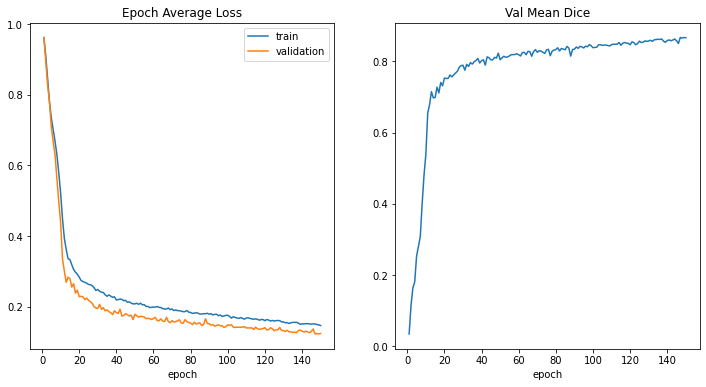

In [11]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_train_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_train_loss_values, label="train")
plt.plot(x, epoch_validation_loss_values, label= "validation")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Inference

N foreground 13080, N  background 0,unable to generate class balanced samples.
N foreground 13981, N  background 0,unable to generate class balanced samples.
N foreground 14351, N  background 0,unable to generate class balanced samples.
N foreground 14149, N  background 0,unable to generate class balanced samples.
N foreground 18264, N  background 0,unable to generate class balanced samples.
N foreground 16021, N  background 0,unable to generate class balanced samples.
N foreground 10539, N  background 0,unable to generate class balanced samples.
N foreground 14458, N  background 0,unable to generate class balanced samples.
N foreground 14199, N  background 0,unable to generate class balanced samples.


Total DSC is 0.8668476343154907. 
Total IoU score is 0.7795029878616333.
Dice per class: [0.8896395564079285, 0.8992692232131958, 0.9160619974136353, 0.8916614055633545, 0.9117871522903442, 0.9019656777381897, 0.9160515069961548, 0.8964811563491821]. 
IoU per class: [0.8049761056900024, 0.8198151588439941, 0.848006010055542, 0.8070598840713501, 0.8394085168838501, 0.8246002793312073, 0.8464964628219604, 0.8150017857551575]


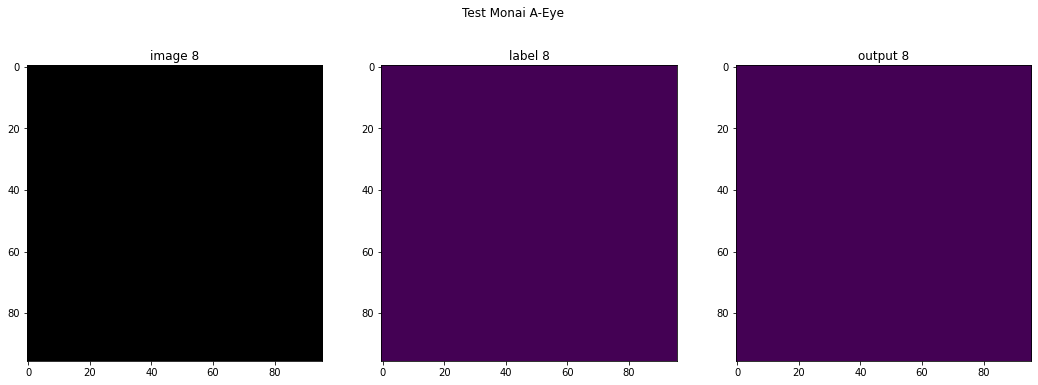

In [12]:
import SimpleITK as sitk

FILE = "3dmultilabel_v2.pth"

# device = torch.device("cuda:0")
# model = UNet(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 10,
#     channels = (16, 32, 64, 128, 256),
#     strides = (2, 2, 2, 2),
#     num_res_units = 2,
#     norm = Norm.BATCH,
#     dropout = 0.5
# ).to(device)

model.load_state_dict(torch.load(
    os.path.join(main_dir, FILE)))

# IoU metric
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=10)])
post_label = Compose([AsDiscrete(to_onehot=10)])
iou_metric = MeanIoU(include_background=False, reduction="mean")
metric_iou_values = []

model.eval()

test_loader = validation_loader # This is not right, but just to test and compute similarity metrics

with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        test_inputs, test_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (160, 160, 160)
        sw_batch_size = 4

        val_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model
        )

        test_outputs = [post_pred(j) for j in decollate_batch(val_outputs)]
        test_labels = [post_label(j) for j in decollate_batch(test_labels)]
        iou_metric(y_pred=test_outputs, y=test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)

        # plot the slice [:, :, 80]
        fig = plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 70], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 70])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 70])
        # print(val_outputs.shape)
        im_result = sitk.GetImageFromArray(np.transpose(torch.argmax(val_outputs, dim=1).detach().cpu().numpy(), (3,2,1,0)))
        if i == 0:
            sitk.WriteImage(im_result, main_dir+'result_'+str(i)+'.nii.gz')
        fig.suptitle('Test Monai A-Eye')
        # plt.show()
    
    # aggregate the final mean dice and IoU results
    dice_array = dice_metric.get_buffer()
    test_metric_dice = dice_metric.aggregate().item()
    iou_array = iou_metric.get_buffer() #(9, 10) --> 25 subjects and 10 classes
    test_metric_iou = iou_metric.aggregate().item()
    print(f"Total DSC is {test_metric_dice}. \nTotal IoU score is {test_metric_iou}.")
    
    # DSC per class
    dice_array_n = dice_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    dice_array_mean = []
    for i, val in enumerate(dice_array_n):
        dice_array_mean.append(torch.mean(dice_array_n[:, i]).item())

    # IoU per class
    iou_array_n = iou_array[:,:-1].transpose(0, 1) # to get in each line the IoU of each class (and eliminate NaN values of backgrounf)--> (6, 25)
    iou_array_mean = []
    for i, val in enumerate(iou_array_n):
        iou_array_mean.append(torch.mean(iou_array_n[:, i]).item())

    print(f"Dice per class: {dice_array_mean}. \nIoU per class: {iou_array_mean}")